## Librairies
---

In [7]:
import zipfile
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import soundfile
import scipy.signal as signal
import librosa.feature as feat
import pandas as pd
import matplotlib.pyplot as plt

## X_train, X_test, Y_train et pos_label
--- 

In [ ]:
X_train= pd.read_csv('features_train.csv')
X_train.head()

In [ ]:
X_Test= pd.read_csv('features_test.csv')
X_Test.head()

In [9]:
Y_train= pd.read_csv('Y_train_ofTdMHi.csv')
Y_train.head()

,id,pos_label
0,00000-JAM.wav,0.0
1,00001-JAM.wav,1.0
2,00002-JAM.wav,1.0
3,00003-JAM.wav,1.0
4,00004-JAM.wav,1.0


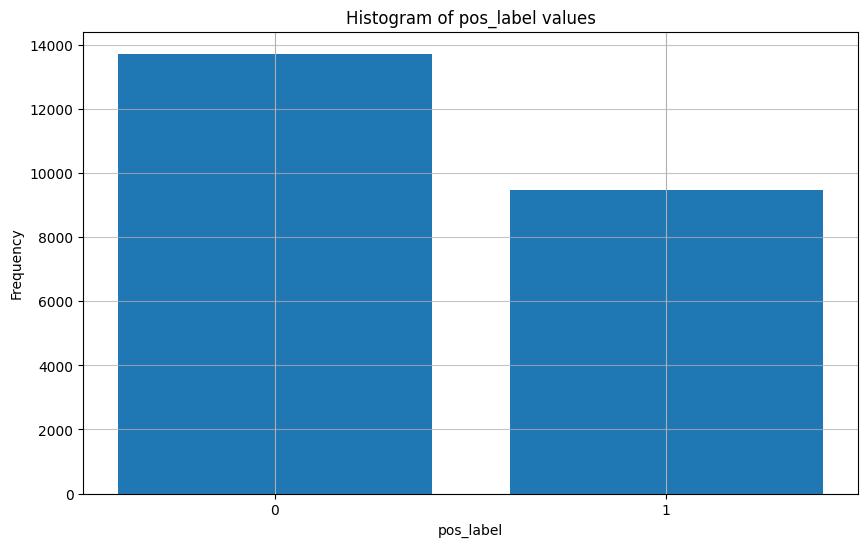

In [11]:
y_train_path = 'Y_train_ofTdMHi.csv'
y_train_df = pd.read_csv(y_train_path)

plt.figure(figsize=(10, 6))
y_train_df['pos_label'].hist(bins=np.arange(-0.5, y_train_df['pos_label'].max()+1.5), rwidth=0.8)
plt.title('Histogram of pos_label values')
plt.xlabel('pos_label')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, y_train_df['pos_label'].max()+1))
plt.grid(axis='y', alpha=0.75)
plt.show()

## v1 XGBoost   0.65
---

### Fonctions 


In [10]:
def unzip_audio(zip_path, extract_folder):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)


def process_audio_file(filename):
    try:
        sig, sr = sf.read(filename)

        nyquist = sr / 2
        low = 5000
        high = min(10000, nyquist)  # Adjust the high frequency to be within Nyquist limit
        sos = signal.butter(6, [low, high], 'bandpass', fs=sr, output='sos')
        filtered_sig = signal.sosfiltfilt(sos, sig)

        rms = feat.rms(y=filtered_sig)
        sc = feat.spectral_centroid(y=filtered_sig, sr=sr)
        sb = feat.spectral_bandwidth(y=filtered_sig, sr=sr)
        spectral_flatness = feat.spectral_flatness(y=filtered_sig)

        features = [np.mean(rms), np.std(rms), np.min(rms), np.max(rms),
                    np.mean(sc), np.std(sc), np.min(sc), np.max(sc),
                    np.mean(sb), np.std(sb), np.min(sb), np.max(sb),
                    np.mean(spectral_flatness), np.std(spectral_flatness), np.min(spectral_flatness), np.max(spectral_flatness)]
        return features
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {filename}: {e}")
        return None



### Paramètres 
---

In [11]:
feature_names = ['rms_mean', 'rms_std', 'rms_min', 'rms_max',
                 'sc_mean', 'sc_std', 'sc_min', 'sc_max',
                 'sb_mean', 'sb_std', 'sb_min', 'sb_max',
                 'sf_mean', 'sf_std', 'sf_min', 'sf_max']

### Extraction
---
On va piocher dans le zip X_train puis on transforme tout en audio

In [5]:
zip_path = 'X_train_uxZx70c.zip'
extract_folder = 'extracted_audio'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

audio_files = []
for filename in os.listdir(extract_folder):
    if filename.endswith('.wav'):
        file_path = os.path.join(extract_folder, filename)
        data, sampling_rate = librosa.load(file_path, sr=None)  
        audio_files.append(data)


############################################################


zip_path_test = 'X_test_CAWNWce.zip'
extract_folder_test = 'extracted_audio_test'

with zipfile.ZipFile(zip_path_test, 'r') as zip_ref_test:
    zip_ref_test.extractall(extract_folder_test)

audio_files_test = []
for filename in os.listdir(extract_folder_test):
    if filename.endswith('.wav'):
        file_path_test = os.path.join(extract_folder_test, filename)
        data_test, sampling_rate_test = librosa.load(file_path_test, sr=None)  
        audio_files.append(data_test)


### Features
---
Je récupère toutes les features en analysant tous les signaux puis je les stocke dans un dataframe

In [12]:
audio_folder = os.path.join('extracted_audio', 'X_train')
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]
audio_paths = [os.path.join(audio_folder, f) for f in audio_files]

all_features = []
all_ids = []
for file in audio_files:
    features = process_audio_file(os.path.join(audio_folder, file))
    if features is not None:  
        all_features.append(features)
        all_ids.append(file)  

df_features = pd.DataFrame(all_features, columns=feature_names)
df_features['id'] = all_ids 
print(df_features.head(1))

[0.0001382524, 3.254202e-05, 8.634549e-05, 0.0002887321, 7781.177237879891, 391.95951980095754, 7254.53875664851, 11051.402618255754, 1805.645964425057, 1583.638709646482, 1398.4913771486335, 14430.16975702926, 2.0231614171563582e-05, 3.325641653206615e-05, 1.8479498158047725e-06, 0.00034741862947545494]
[0.00013746647, 1.8566716e-05, 7.634045e-05, 0.0001870673, 7784.976158801087, 283.4382476581286, 7368.9199743578065, 9908.307604485639, 1802.0829710213507, 1427.1350284796874, 1348.8851976677827, 12598.329297092752, 2.0930810245896196e-05, 3.903917263685595e-05, 6.6102352174916865e-06, 0.0004040712902793861]
[0.00013359984, 1.7843904e-05, 7.3960815e-05, 0.00018655416, 7775.686706581279, 279.5703022156349, 7377.3784412230525, 9878.785230486012, 1809.8333802020256, 1452.3629917467858, 1353.1136879734026, 12514.762100620414, 2.5496297271694075e-05, 7.351370320802352e-05, 8.161247796566053e-06, 0.0007481399207387005]
[0.00013318942, 1.4863583e-05, 9.850389e-05, 0.0001852043, 7794.458273731

KeyboardInterrupt: 

In [ ]:
audio_folder_test = os.path.join('extracted_audio_test', 'X_test')
audio_files_test = [f for f in os.listdir(audio_folder_test) if f.endswith('.wav')]
audio_paths_test = [os.path.join(audio_folder_test, f) for f in audio_files_test]

all_features_test = []
all_ids_test = []
for file in audio_files_test:
    features_test = process_audio_file(os.path.join(audio_folder_test, file))
    if features_test is not None:  
        all_features_test.append(features_test)  
        all_ids_test.append(file) 

df_features_test = pd.DataFrame(all_features_test, columns=feature_names)
df_features_test['id'] = all_ids_test  
print(df_features_test.head(1))

### Main
---
Premier essai avec validation croisée

In [7]:
X = df_features.drop(columns=['id'])
y = Y_train['pos_label']

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=53)

kf = KFold(n_splits=5, shuffle=True, random_state=53)
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Précision moyenne de la validation croisée : {cv_scores.mean() * 100:.2f}%")
print(f"Écart-type de la validation croisée : {cv_scores.std() * 100:.2f}%")

# Entraîner le modèle sur l'ensemble des données d'entraînement
model.fit(X_train, y_train)

# Évaluer la précision sur l'ensemble de validation
y_val_pred = model.predict(X_val)
print(f"Précision sur l'ensemble de validation : {accuracy_score(y_val, y_val_pred) * 100:.2f}%")


ValueError: Found input variables with inconsistent numbers of samples: [0, 23168]

### X_test
---

In [ ]:
X = df_features_test.drop(columns=['id'])

y_test_pred = model.predict(X)

# Créer un DataFrame pour le rendu final qui contient les identifiants et les prédictions
df_final = pd.DataFrame({
    'id': all_ids_test,  # Liste des identifiants de l'ensemble de test
    'predicted_label': y_test_pred
})

# Exporter le DataFrame final en tant que fichier CSV
df_final.to_csv('final_predictions.csv', index=False)

## v1 DecisionTree
--- 
DecisionTree avec ou sans validation croisée


In [ ]:
'''import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Charger les caractéristiques et les étiquettes
Y_train = pd.read_csv('Y_train_ofTdMHi.csv')

# Exclure la colonne 'id' de df_features avant la division
X = df_features.drop(columns=['id'])

# y est l'ensemble de vos étiquettes
y = Y_train['pos_label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

# Créer le modèle d'arbre de décision
tree_model = DecisionTreeClassifier()

# Entraîner le modèle
tree_model.fit(X_train, y_train)

# Prédire les étiquettes pour l'ensemble de test
y_pred = tree_model.predict(X_test)

# Évaluer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision : {accuracy * 100:.2f}%")
'''

'import pandas as pd\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Charger les caractéristiques et les étiquettes\nY_train = pd.read_csv(\'Y_train_ofTdMHi.csv\')\n\n# Exclure la colonne \'id\' de df_features avant la division\nX = df_features.drop(columns=[\'id\'])\n\n# y est l\'ensemble de vos étiquettes\ny = Y_train[\'pos_label\']\n\n# Diviser les données en ensembles d\'entraînement et de test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)\n\n# Créer le modèle d\'arbre de décision\ntree_model = DecisionTreeClassifier()\n\n# Entraîner le modèle\ntree_model.fit(X_train, y_train)\n\n# Prédire les étiquettes pour l\'ensemble de test\ny_pred = tree_model.predict(X_test)\n\n# Évaluer la précision\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Précision : {accuracy * 100:.2f}%")\n'

In [ ]:
'''import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Charger les caractéristiques et les étiquettes
Y_train = pd.read_csv('Y_train_ofTdMHi.csv')

# Exclure la colonne 'id' de df_features avant la division
X = df_features.drop(columns=['id'])

# y est l'ensemble de vos étiquettes
y = Y_train['pos_label']

# Créer le modèle d'arbre de décision
tree_model = DecisionTreeClassifier()

# Validation croisée
cv_scores = cross_val_score(tree_model, X, y, cv=5)  # 5 plis de validation croisée

# Imprimer les scores de précision pour chaque pli
print(f"Scores de précision de la validation croisée : {cv_scores}")

# Imprimer la précision moyenne de la validation croisée
print(f"Précision moyenne de la validation croisée : {cv_scores.mean() * 100:.2f}%")
'''

'import pandas as pd\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.metrics import accuracy_score\n\n# Charger les caractéristiques et les étiquettes\nY_train = pd.read_csv(\'Y_train_ofTdMHi.csv\')\n\n# Exclure la colonne \'id\' de df_features avant la division\nX = df_features.drop(columns=[\'id\'])\n\n# y est l\'ensemble de vos étiquettes\ny = Y_train[\'pos_label\']\n\n# Créer le modèle d\'arbre de décision\ntree_model = DecisionTreeClassifier()\n\n# Validation croisée\ncv_scores = cross_val_score(tree_model, X, y, cv=5)  # 5 plis de validation croisée\n\n# Imprimer les scores de précision pour chaque pli\nprint(f"Scores de précision de la validation croisée : {cv_scores}")\n\n# Imprimer la précision moyenne de la validation croisée\nprint(f"Précision moyenne de la validation croisée : {cv_scores.mean() * 100:.2f}%")\n'

## Réseau de neurones
---


In [16]:
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the training data

# Sort X_train using regex to capture the first five digits of the 'id' column
X_train['sort_id'] = X_train['id'].apply(lambda x: int(re.search(r'^(\d{5}).*', x).group(1)))
X_train_sorted = X_train.sort_values(by='sort_id').drop(['sort_id', 'id'], axis=1)

# Drop the 'id' column from Y_train as it is not needed for training
Y_train_final = Y_train.drop('id', axis=1)

# Define the neural network architecture
model = Sequential([
    Dense(64, input_dim=X_train_sorted.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_sorted, Y_train_final['pos_label'], epochs=10, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_train_sorted, Y_train_final['pos_label'], verbose=0)
print(f"Training Accuracy: {accuracy*100:.2f}%")

# Show the sorted X_train head to confirm sorting
print(X_train_sorted.head())





Epoch 1/10


724/724 [==============================] - 2s 1ms/step - loss: 145.9649 - accuracy: 0.7090
Epoch 2/10
724/724 [==============================] - 1s 1ms/step - loss: 32.9898 - accuracy: 0.7526
Epoch 3/10
724/724 [==============================] - 1s 2ms/step - loss: 39.1525 - accuracy: 0.7510
Epoch 4/10
724/724 [==============================] - 1s 1ms/step - loss: 33.6001 - accuracy: 0.7586
Epoch 5/10
724/724 [==============================] - 1s 1ms/step - loss: 28.6394 - accuracy: 0.7593
Epoch 6/10
724/724 [==============================] - 1s 953us/step - loss: 23.8357 - accuracy: 0.7691
Epoch 7/10
724/724 [==============================] - 1s 990us/step - loss: 30.7441 - accuracy: 0.7591
Epoch 8/10
724/724 [==============================] - 1s 989us/step - loss: 20.9936 - accuracy: 0.7663
Epoch 9/10
724/724 [==============================] - 1s 933us/step - loss: 17.8494 - accuracy: 0.7706
Epoch 10/10
724/724 [==============================] - 1s 995us/step - loss: 

In [20]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the training data
X_train= pd.read_csv('features_train.csv')
Y_train= pd.read_csv('Y_train_ofTdMHi.csv')

# Assuming the first five characters of the 'id' need to be sorted in X_train
X_train['sort_id'] = X_train['id'].apply(lambda x: int(re.search(r'^(\d{5}).*', x).group(1)))
X_train_sorted = X_train.sort_values(by='sort_id').drop(['sort_id', 'id'], axis=1)

# Drop the 'id' column from Y_train as it is not needed for training
Y_train_final = Y_train.drop('id', axis=1)

# Define the neural network architecture
model = Sequential([
    Dense(64, input_dim=X_train_sorted.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_sorted, Y_train_final['pos_label'], epochs=10, batch_size=32, verbose=1)

# Load the test data
X_Test= pd.read_csv('features_test.csv')

# Preprocess X_test the same way as X_train was preprocessed
X_test['sort_id'] = X_test['id'].apply(lambda x: int(re.search(r'^(\d{5}).*', x).group(1)))
X_test_sorted = X_test.sort_values(by='sort_id').drop(['sort_id', 'id'], axis=1)

# Use the model to predict the outcomes for the X_test data
predictions = model.predict(X_test_sorted)

# For binary classification, we will threshold predictions at 0.5
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame with the required structure
results_df = pd.DataFrame({
    'id': X_test['id'],
    'pos_label': predicted_labels
})

# Save the results to a CSV file
results_path = 'pred2.csv'
results_df.to_csv(results_path, index=False)

print(f"Predictions saved to {results_path}")


Epoch 1/10
724/724 [==============================] - 1s 965us/step - loss: 103.8709 - accuracy: 0.7400
Epoch 2/10
724/724 [==============================] - 1s 919us/step - loss: 32.1133 - accuracy: 0.7520
Epoch 3/10
724/724 [==============================] - 1s 966us/step - loss: 25.5466 - accuracy: 0.7667
Epoch 4/10
724/724 [==============================] - 1s 936us/step - loss: 24.9365 - accuracy: 0.7608
Epoch 5/10
724/724 [==============================] - 1s 937us/step - loss: 20.1124 - accuracy: 0.7709
Epoch 6/10
724/724 [==============================] - 1s 934us/step - loss: 16.6125 - accuracy: 0.7794
Epoch 7/10
724/724 [==============================] - 1s 955us/step - loss: 17.7314 - accuracy: 0.7743
Epoch 8/10
724/724 [==============================] - 1s 918us/step - loss: 19.6471 - accuracy: 0.7667
Epoch 9/10
724/724 [==============================] - 1s 926us/step - loss: 14.2735 - accuracy: 0.7803
Epoch 10/10
30/30 [==============================] - 0s 848us/step
Predi

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the training data
X_train= pd.read_csv('features_train.csv')
Y_train= pd.read_csv('Y_train_ofTdMHi.csv')

# Assuming the first five characters of the 'id' need to be sorted in X_train
X_train['sort_id'] = X_train['id'].apply(lambda x: int(re.search(r'^(\d{5}).*', x).group(1)))
X_train_sorted = X_train.sort_values(by='sort_id').drop(['sort_id', 'id'], axis=1)

# Drop the 'id' column from Y_train as it is not needed for training
Y_train_final = Y_train.drop('id', axis=1)

# Define the K-Fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = []

for train, val in kfold.split(X_train_sorted):
    # Define the model architecture
    model = Sequential([
        Dense(64, input_shape=(X_train_sorted.shape[1],), activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Select the training and validation data
    X_train_fold, Y_train_fold = X_train_sorted.iloc[train], Y_train_final.iloc[train]
    X_val_fold, Y_val_fold = X_train_sorted.iloc[val], Y_train_final.iloc[val]
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)
    
    # Train the model
    model.fit(X_train_fold, Y_train_fold, epochs=20, batch_size=32, verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(X_val_fold, Y_val_fold, verbose=0)
    print(f'Validation accuracy for fold {len(cv_scores)+1}: {scores[1]*100:.2f}%')
    cv_scores.append(scores[1])  # Assumes accuracy is the second score returned by model.evaluate

# Calculate average performance across all folds
average_accuracy = np.mean(cv_scores)
print(f'Average Cross-Validation Accuracy: {average_accuracy*100:.2f}%')


Validation accuracy for fold 1: 92.49%
Validation accuracy for fold 2: 91.93%
Validation accuracy for fold 3: 92.90%
Validation accuracy for fold 4: 92.23%
Validation accuracy for fold 5: 92.25%
Average Cross-Validation Accuracy: 92.36%


## v2 Neurones Spectrogrammes
---

20 spectrogrammes traités.
40 spectrogrammes traités.
60 spectrogrammes traités.
80 spectrogrammes traités.
100 spectrogrammes traités.
120 spectrogrammes traités.
140 spectrogrammes traités.
160 spectrogrammes traités.
180 spectrogrammes traités.
200 spectrogrammes traités.
220 spectrogrammes traités.
240 spectrogrammes traités.
260 spectrogrammes traités.
280 spectrogrammes traités.
300 spectrogrammes traités.
320 spectrogrammes traités.
340 spectrogrammes traités.
360 spectrogrammes traités.
380 spectrogrammes traités.
400 spectrogrammes traités.
420 spectrogrammes traités.
440 spectrogrammes traités.
460 spectrogrammes traités.
480 spectrogrammes traités.
500 spectrogrammes traités.
520 spectrogrammes traités.
540 spectrogrammes traités.
560 spectrogrammes traités.
580 spectrogrammes traités.
600 spectrogrammes traités.
620 spectrogrammes traités.
640 spectrogrammes traités.
660 spectrogrammes traités.
680 spectrogrammes traités.
700 spectrogrammes traités.
720 spectrogrammes trait

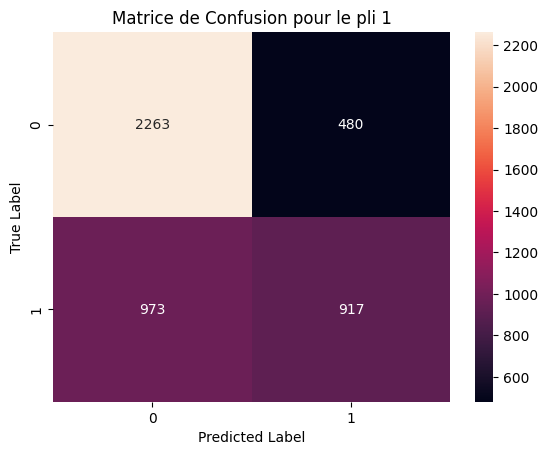

145/145 [==============================] - 1s 3ms/step


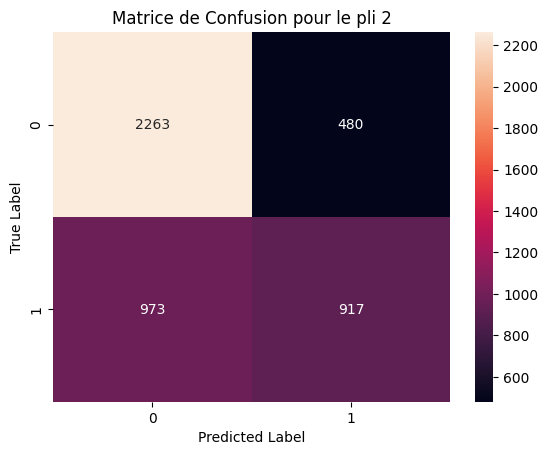

145/145 [==============================] - 1s 4ms/step


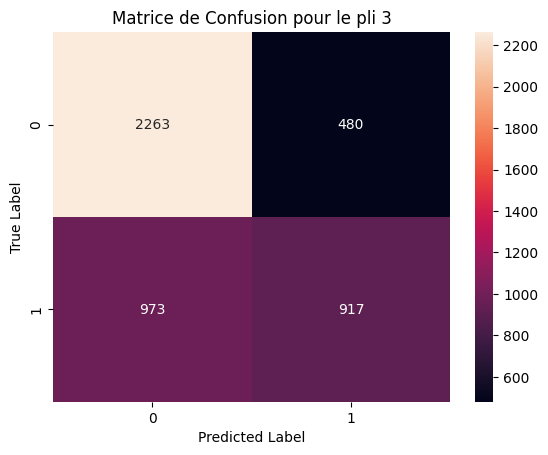

145/145 [==============================] - 1s 4ms/step


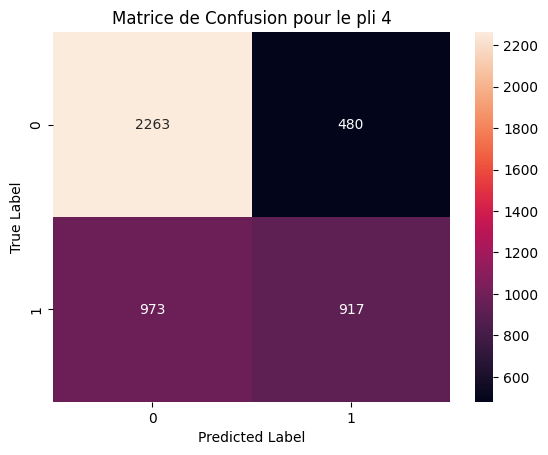

145/145 [==============================] - 1s 3ms/step


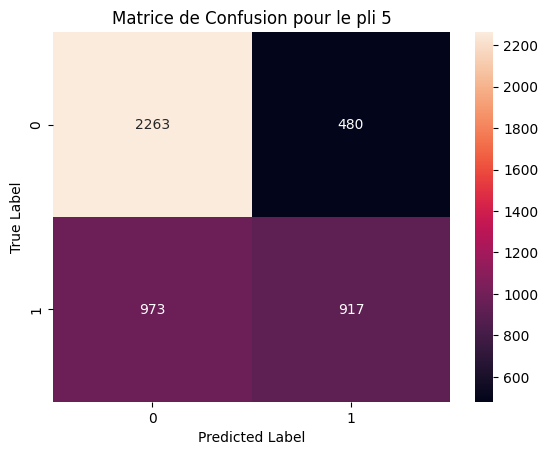

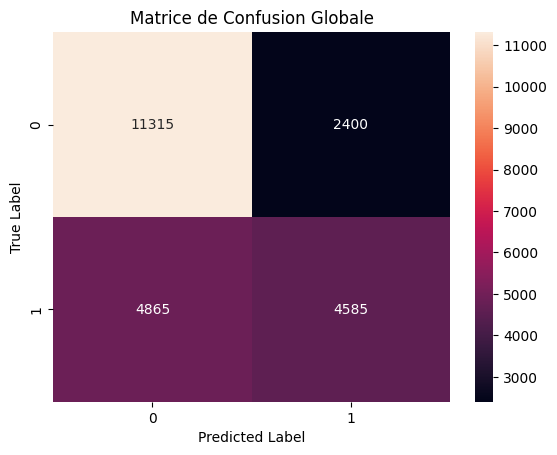

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Chargement des étiquettes
y_train_path = 'Y_train_ofTdMHi.csv'
y_train_df = pd.read_csv(y_train_path)

# Chemin vers les fichiers audio
audio_dir = 'extracted_audio/X_train/'

# Fonction pour créer des spectrogrammes à partir des fichiers audio
def create_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    spect = librosa.feature.melspectrogram(y=y, sr=sr)
    spect = librosa.power_to_db(spect, ref=np.max)
    spect = spect.astype(np.float32) # Pour compatibilité avec TensorFlow
    return spect

# Prétraitement des fichiers audio
def preprocess_data(y_train_df, audio_dir):
    X_spect = []
    y_labels = []

    # Traitement des fichiers dans l'ordre du dataframe
    for index, row in enumerate(y_train_df.itertuples(), 1):  # Commence l'indexation à 1
        audio_path = os.path.join(audio_dir, row.id)
        if os.path.isfile(audio_path):
            spect = create_spectrogram(audio_path)
            X_spect.append(spect)
            y_labels.append(row.pos_label)
            
            # Imprime un message tous les 20 spectrogrammes
            if index % 20 == 0:
                print(f"{index} spectrogrammes traités.")
        else:
            print(f"Le fichier {row.id} n'a pas été trouvé dans le répertoire.")
    
    X_spect = np.array(X_spect)
    X_spect = np.expand_dims(X_spect, axis=-1) # Ajout de la dimension de canal

    # Encodage des étiquettes
    y_labels = np.array(y_labels)
    le = LabelEncoder()
    y_labels_encoded = le.fit_transform(y_labels)
    y_categorical = to_categorical(y_labels_encoded)

    return X_spect, y_categorical


def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(2, 2), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Traitement des données
X_spect, y_categorical = preprocess_data(y_train_df, audio_dir)

import json

# Dictionnaire pour stocker les scores de chaque pli
scores = {}

# Validation croisée
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_spect, np.argmax(y_categorical, axis=1))):
    print(f'Début du pli {fold + 1}')
    X_train, X_val = X_spect[train_idx], X_spect[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Création du modèle pour le pli actuel
    model = create_cnn_model(X_train.shape[1:], y_categorical.shape[1])
    
    # Entraînement du modèle
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Évaluation du modèle sur l'ensemble de validation
    score = model.evaluate(X_val, y_val, verbose=0)
    print(f'Résultats pour le pli {fold + 1}:')
    print(f'Test Loss: {score[0]}')
    print(f'Test Accuracy: {score[1]}')
    
    # Sauvegarde des métriques pour analyse
    scores[f'fold_{fold + 1}'] = {
        'loss': score[0],
        'accuracy': score[1]
    }

    # Sauvegarde des métriques d'entraînement pour analyse
    with open(f'training_history_fold_{fold + 1}.json', 'w') as f:
        json.dump(history.history, f)

# ... (le code précédent reste inchangé)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialisation d'une liste pour collecter les vraies étiquettes et les prédictions
true_labels = []
predicted_labels = []

# Validation croisée avec matrice de confusion
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_spect, np.argmax(y_categorical, axis=1))):
    # ... (le reste de la boucle de validation croisée reste inchangé)

    # Prédire les classes pour l'ensemble de validation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Ajouter les vraies étiquettes et les prédictions aux listes
    true_labels.extend(y_true_classes)
    predicted_labels.extend(y_pred_classes)

    # Calcul et affichage de la matrice de confusion pour le pli actuel
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Matrice de Confusion pour le pli {fold + 1}')
    plt.show()

# Générer la matrice de confusion globale pour tous les plis
cm_global = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm_global, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Matrice de Confusion Globale')
plt.show()

# Enregistrez le modèle après la validation croisée si vous souhaitez faire des prédictions ultérieurement
model.save('modele_cnn_audio_final.h5')



In [30]:
import os
import numpy as np
import pandas as pd
import librosa
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Supposons que `model_path` est le chemin vers votre modèle entraîné
model = load_model('modele_cnn_audio_final.h5')

# Ou utilisez le modèle déjà en mémoire si vous venez juste de l'entraîner.

# Fonction pour prétraiter les nouveaux extraits audio
def preprocess_new_audio(audio_dir):
    X_new = []
    file_names = []
    for file in os.listdir(audio_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(audio_dir, file)
            spect = create_spectrogram(file_path)
            X_new.append(spect)
            file_names.append(file)
    X_new = np.array(X_new)
    X_new = np.expand_dims(X_new, axis=-1)
    return X_new, file_names

# Fonction pour prédire et sauvegarder les résultats
def predict_and_save(model, audio_dir, le, output_csv_path):
    X_new, file_names = preprocess_new_audio(audio_dir)
    predictions = model.predict(X_new)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = le.inverse_transform(predicted_classes)

    # Création d'un DataFrame pour les résultats
    results_df = pd.DataFrame({
        'id': file_names,
        'pos_label': predicted_labels
    })

    # Enregistrez le DataFrame dans le format de 'Y_random.csv'
    results_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

# Emplacement de vos nouveaux extraits audio
new_audio_dir = 'extracted_audio_test/X_test/'

# Encoder pour les étiquettes utilisé pendant l'entraînement
le = LabelEncoder()
le.fit(y_train_df['pos_label'].unique())


# Chemin où le fichier CSV des prédictions sera enregistré
output_csv_path = 'predictions_cnn_spec.csv'

# Faire des prédictions et sauvegarder les résultats
predict_and_save(model, new_audio_dir, le, output_csv_path)


30/30 [==============================] - 0s 3ms/step
Predictions saved to predictions_cnn_spec.csv


## Essais régions
---

In [ ]:
import os
import shutil

# Définissez le chemin vers le dossier source et le dossier de destination
source_folder = 'extracted_audio/X_train/'  # Remplacez par le chemin de votre dossier source
destination_folder = 'quatre_regions_audios'  # Remplacez par le chemin de votre dossier de destination

# Créez le dossier de destination s'il n'existe pas
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Définissez les chaînes de caractères que vous recherchez dans les titres des fichiers
patterns = ['StMARTIN', 'StEUS', 'ARUBA', 'JAM']

# Parcourez tous les fichiers dans le dossier source
for filename in os.listdir(source_folder):
    # Vérifiez si le nom du fichier contient l'une des chaînes de caractères spécifiées
    if any(pattern in filename for pattern in patterns):
        # Construisez le chemin complet vers les fichiers source et de destination
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        # Copiez le fichier dans le dossier de destination
        shutil.copy2(source_path, destination_path)

print(f'Les fichiers ont été copiés dans {destination_folder}')

In [18]:
import os

# Remplacez 'your_folder_path' par le chemin d'accès à votre dossier
folder_path = 'quatre_regions_audios'

try:
    items = os.listdir(folder_path)
    num_items = len(items)
    print(f'Il y a {num_items} élément(s) dans le dossier.')
except FileNotFoundError:
    print('Le dossier spécifié est introuvable.')


Il y a 9181 élément(s) dans le dossier.


In [33]:
import os
from collections import Counter

# Définir le chemin du dossier contenant vos fichiers audio
audio_folder = 'extracted_audio'
sub_folder = 'X_train'

# Combiner les chemins pour obtenir le chemin complet vers les fichiers audio
full_path = os.path.join(audio_folder, sub_folder)

# Lister tous les fichiers dans le sous-dossier
file_names = [name for name in os.listdir(full_path) if name.endswith('.wav')]

# Extraire les codes de région des noms de fichiers
region_codes = [name.split('-')[1].split('.')[0] for name in file_names]

# Compter les occurrences de chaque code de région
region_count = Counter(region_codes)

# Afficher le compte de chaque région
for region, count in region_count.items():
    print(f"{region}: {count}")


JAM: 2902
StEUS: 815
BON: 4952
BAHAMAS: 290
GUA: 8459
ARUBA: 856
StMARTIN: 4608
BERMUDE: 286


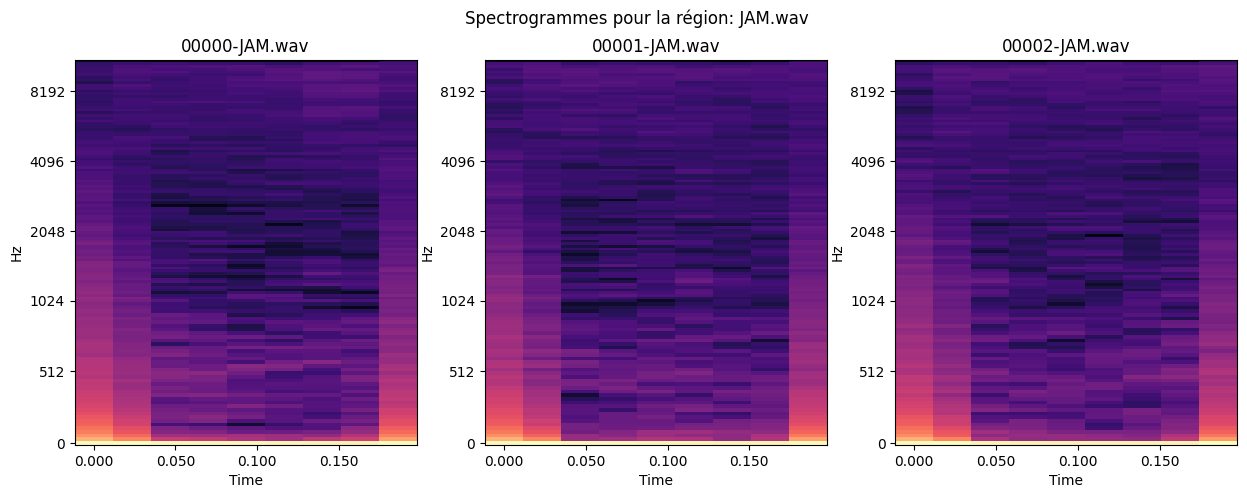

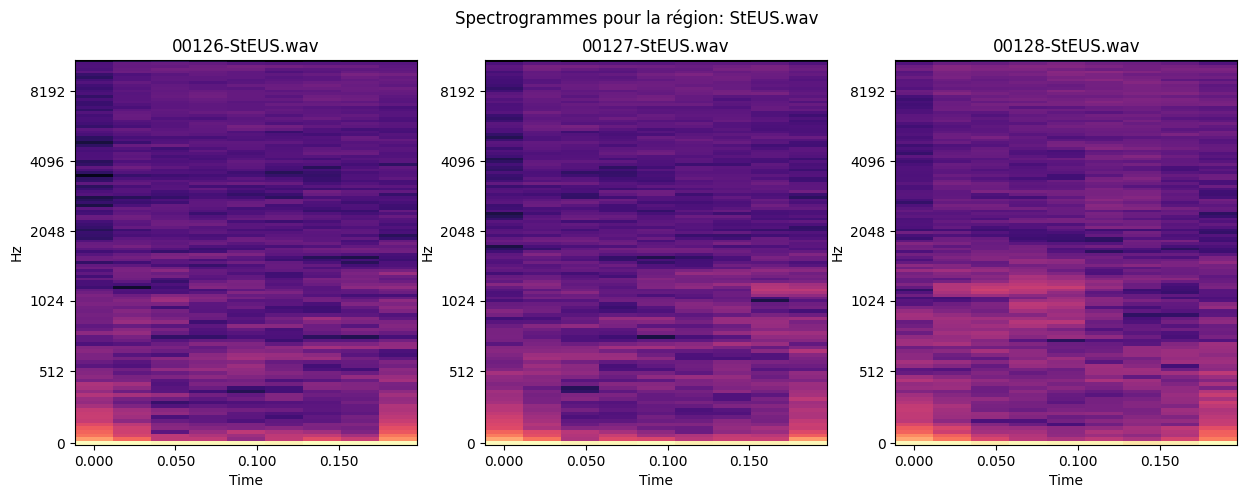

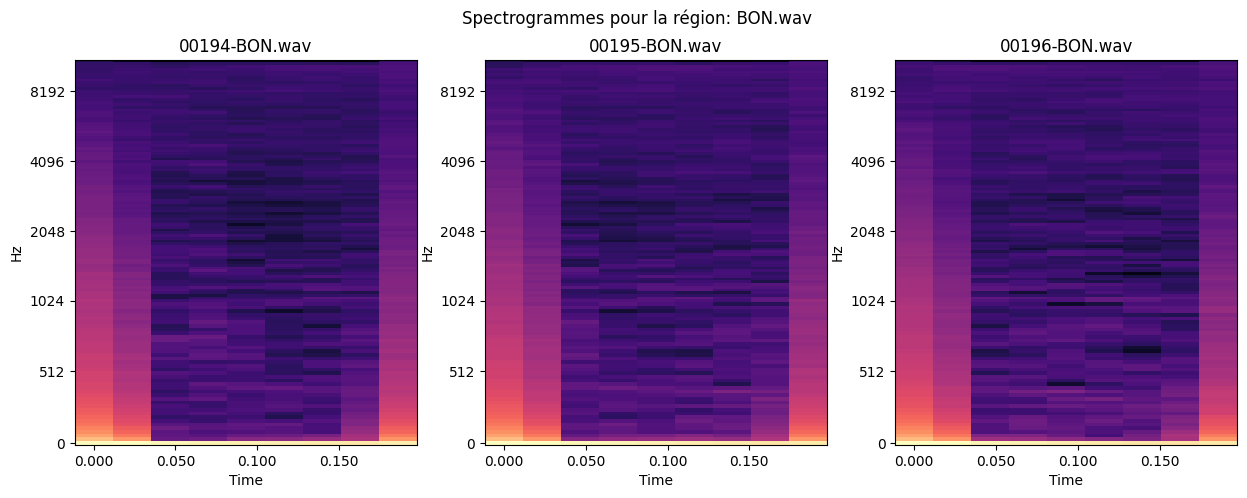

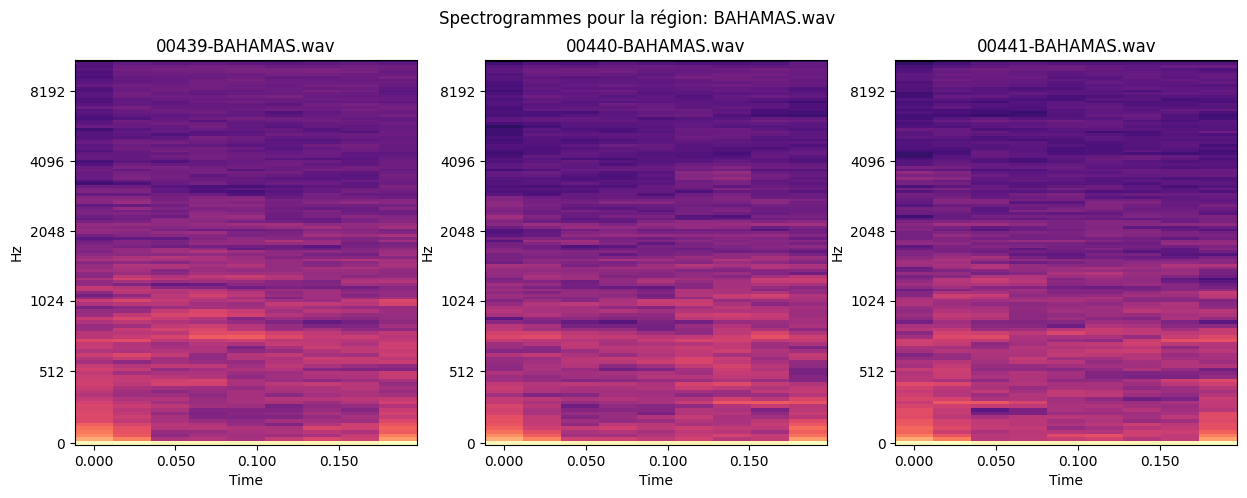

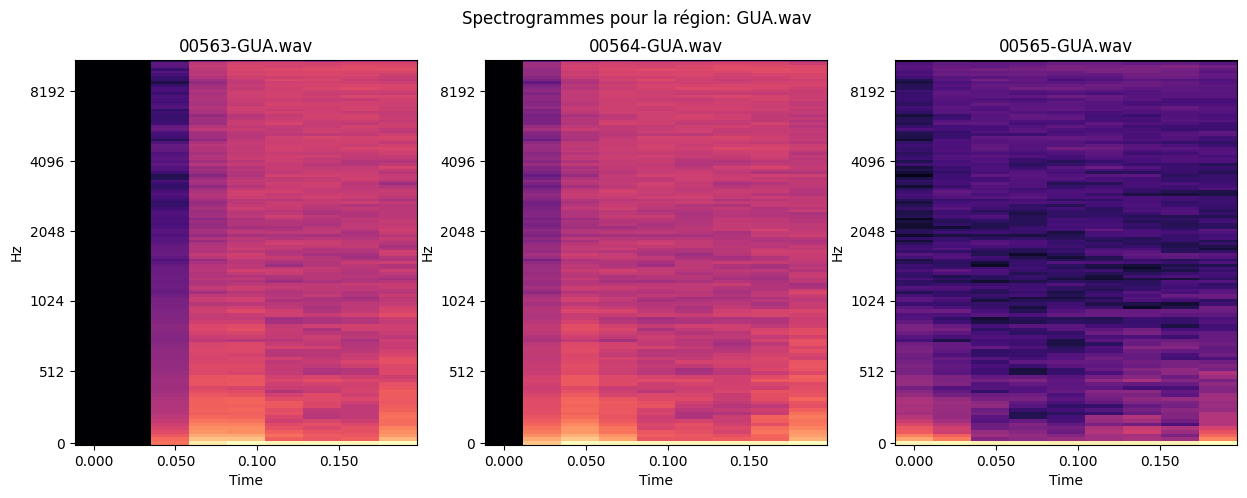

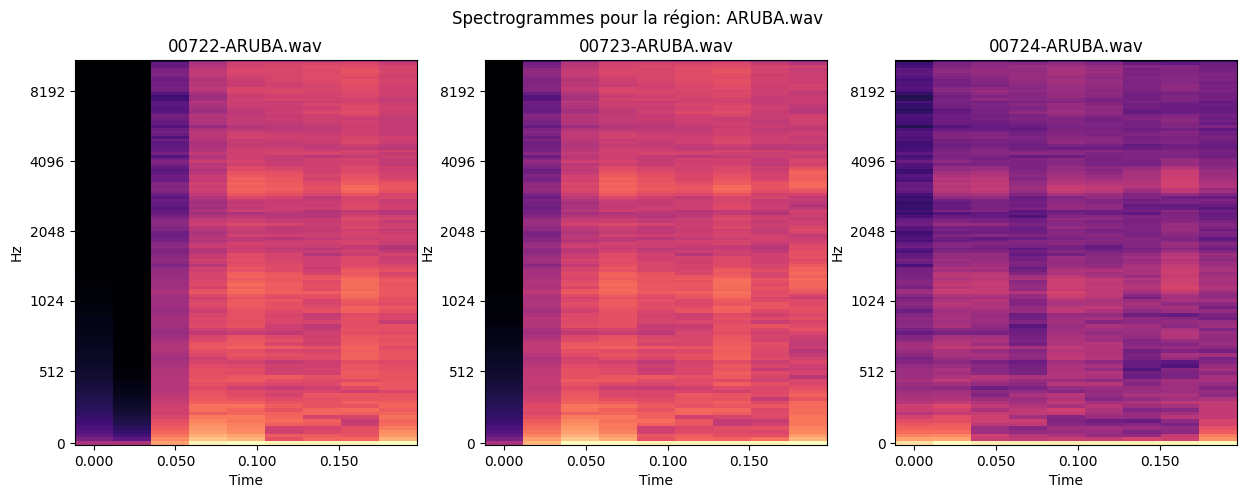

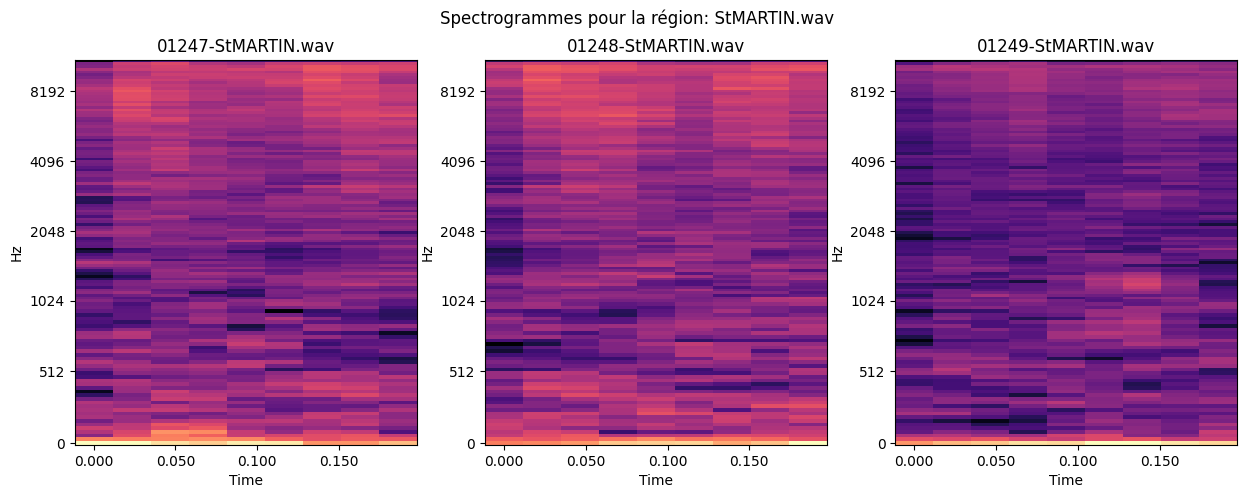

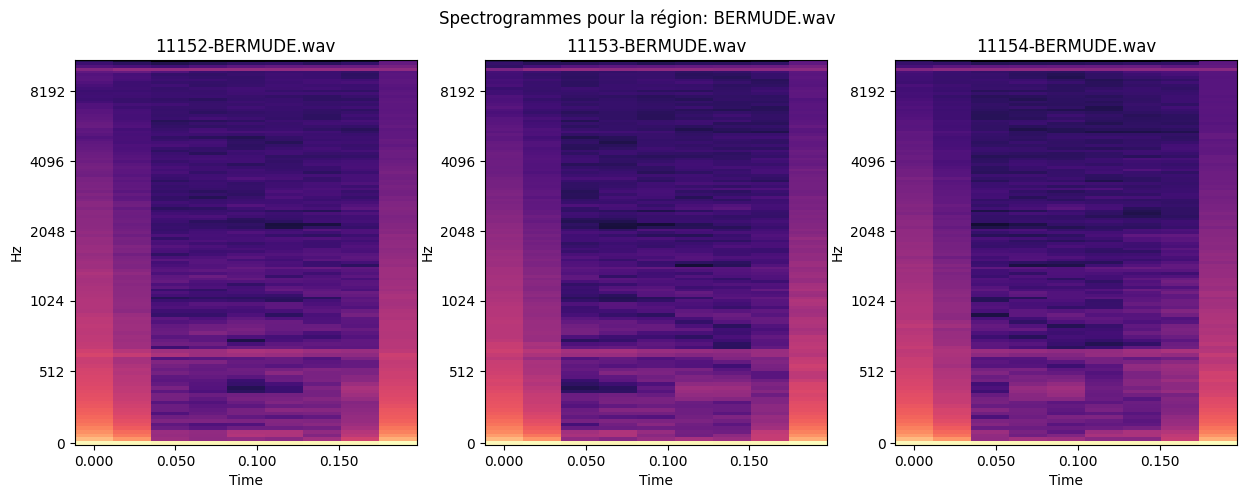

In [39]:
import os
import matplotlib.pyplot as plt
import librosa.display

# Supposons que `audio_dir` est votre répertoire contenant des sous-répertoires pour chaque région
audio_dir = 'extracted_audio/X_train'

# Collecter les fichiers audio par région
audio_files_by_region = {}
for subdir, dirs, files in os.walk(audio_dir):
    for file in files:
        if file.endswith('.wav'):
            region = file.split('-')[1]  # Supposons que le format est XXXXX-REGION.wav
            if region not in audio_files_by_region:
                audio_files_by_region[region] = []
            audio_files_by_region[region].append(os.path.join(subdir, file))

# Générer des spectrogrammes pour trois fichiers audio par région
for region, files in audio_files_by_region.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Spectrogrammes pour la région: {region}')
    for i, file_path in enumerate(files[:3]):  # Prendre seulement les 3 premiers fichiers
        y, sr = librosa.load(file_path)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        ax = axes[i]
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', ax=ax)
        ax.set_title(os.path.basename(file_path))
    plt.show()


In [2]:
import pandas as pd

# Load the data from the CSV file
file_path = 'features_train.csv'
features_df = pd.read_csv(file_path)

# Ensure that the ID column is of object type for string operations
features_df['id'] = features_df['id'].astype(str)

# Extracting the region codes from the 'id' column
features_df['region'] = features_df['id'].apply(lambda x: x.split('-')[1].split('.')[0])

# Select only numeric columns (excluding 'id' and 'region')
numeric_cols = features_df.select_dtypes(include='number').columns

# Calculating the mean of each numeric feature grouped by region
mean_features_by_region = features_df.groupby('region')[numeric_cols].mean()

# Displaying the first few rows of the resultant DataFrame
mean_features_by_region.head(10)


,rms_mean,rms_std,rms_min,rms_max,sc_mean,sc_std,sc_min,sc_max,sb_mean,sb_std,sb_min,sb_max,sf_mean,sf_std,sf_min,sf_max
region,,,,,,,,,,,,,,,,
ARUBA,0.000606,0.000458,0.000269,0.001924,34997.006094,3175.272524,29521.454550,44334.191011,24985.279973,1081.361496,21726.278317,27581.616417,0.017474,0.009388,0.008328,0.064829
BAHAMAS,0.000360,0.000052,0.000237,0.000544,31955.608465,2805.397114,28005.900587,44493.591120,25199.766003,1066.120489,22058.600001,28852.886761,0.011833,0.005097,0.006732,0.040462
BERMUDE,0.000310,0.000058,0.000198,0.000493,22037.217902,3038.919613,18576.003114,34076.855758,18822.876553,1138.391184,16454.174323,22623.556334,0.004829,0.004399,0.001680,0.020311
BON,0.000696,0.000513,0.000270,0.002468,32356.375989,3798.542863,26938.257449,44891.551050,24426.602095,1191.919229,21113.932757,27350.219107,0.012307,0.006702,0.005443,0.042507
GUA,0.000645,0.000235,0.000359,0.001414,33358.362091,3085.384484,26636.777079,43199.784023,24385.600931,997.875721,21251.936128,26993.136135,0.014972,0.006859,0.006414,0.053237
JAM,0.000355,0.000110,0.000212,0.000742,33512.729899,3392.577039,28688.006001,45980.264346,24913.065441,904.128483,22181.932031,27363.196006,0.017776,0.007527,0.009432,0.055779
StEUS,0.000807,0.000582,0.000329,0.002537,34185.363586,4811.007266,27926.737215,49176.562845,24494.145920,1136.471901,21177.513060,27712.615181,0.013711,0.007458,0.006451,0.049993
StMARTIN,0.000640,0.000216,0.000348,0.001319,36112.815197,3514.869189,28973.025700,46977.184365,25406.736735,1161.857346,22036.093385,28455.717181,0.018355,0.008544,0.007951,0.065423


In [3]:
import pandas as pd

file_path_test = 'features_test.csv'
features_df_test = pd.read_csv(file_path_test)
features_df_test['id'] = features_df_test['id'].astype(str)
features_df_test['region'] = features_df_test['id'].apply(lambda x: x.split('-')[1].split('.')[0])
numeric_cols_test = features_df_test.select_dtypes(include='number').columns
mean_features_test = features_df_test.groupby('region')[numeric_cols_test].mean()
mean_features_test.head(10)

,rms_mean,rms_std,rms_min,rms_max,sc_mean,sc_std,sc_min,sc_max,sb_mean,sb_std,sb_min,sb_max,sf_mean,sf_std,sf_min,sf_max
region,,,,,,,,,,,,,,,,
TEST,0.000434,0.00013,0.000267,0.000893,38091.973431,3373.002023,31686.533094,49143.518421,26936.693207,1301.32428,23337.040263,31432.465405,0.026185,0.019345,0.01192,0.149506


In [60]:
import pandas as pd
from scipy.spatial.distance import euclidean

# Calculer la distance euclidienne de TEST à chaque région
distances = mean_features_by_region.apply(lambda x: euclidean(x, mean_features_test.iloc[0]), axis=1)
print(distances)
# Trouver la région la plus proche de TEST
closest_region = distances.idxmin()
closest_distance = distances.min()

# Afficher la région la plus proche et sa distance à TEST
print(f"La région la plus proche de TEST est {closest_region} avec une distance de {closest_distance}")


region
ARUBA        7662.578171
BAHAMAS      9192.763584
BERMUDE     29113.371442
BON         10080.822379
GUA         10675.826479
JAM          7881.196475
StEUS        7480.686702
StMARTIN     5376.525814
dtype: float64
La région la plus proche de TEST est StMARTIN avec une distance de 5376.525814107626


StMartin 1 -- StEus 2 -- Aruba 3 -- JAM 4

## v3 Neurones focus sur 4 régions     0.5
---

20 spectrogrammes traités.
40 spectrogrammes traités.
60 spectrogrammes traités.
80 spectrogrammes traités.
100 spectrogrammes traités.
120 spectrogrammes traités.
140 spectrogrammes traités.
160 spectrogrammes traités.
180 spectrogrammes traités.
Le fichier 00194-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00195-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00196-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00197-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00198-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00199-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00200-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00201-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00202-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00203-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00204-BON.wav n'a pas été trouvé dans le répertoire.
Le fichier 00205-BON.wav n'a pas été trouvé dans

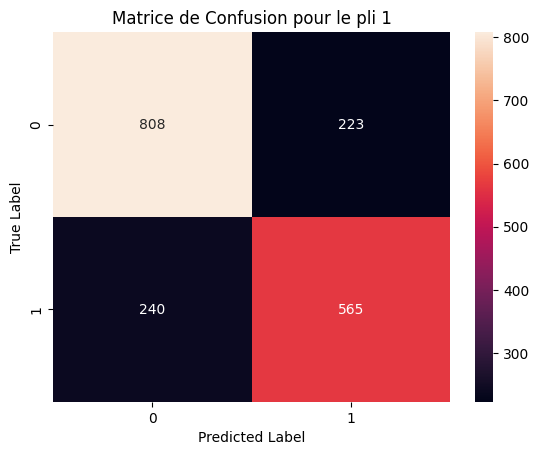

58/58 [==============================] - 0s 2ms/step


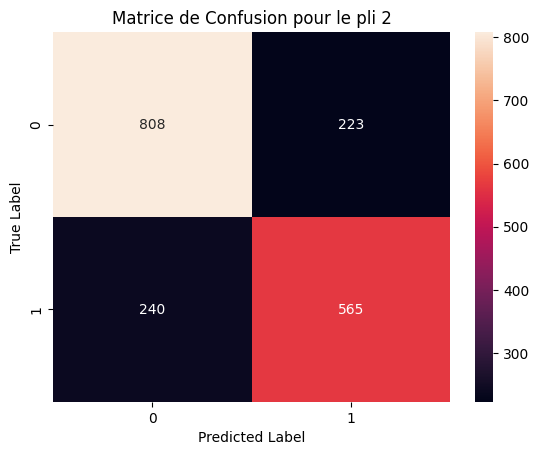

58/58 [==============================] - 0s 2ms/step


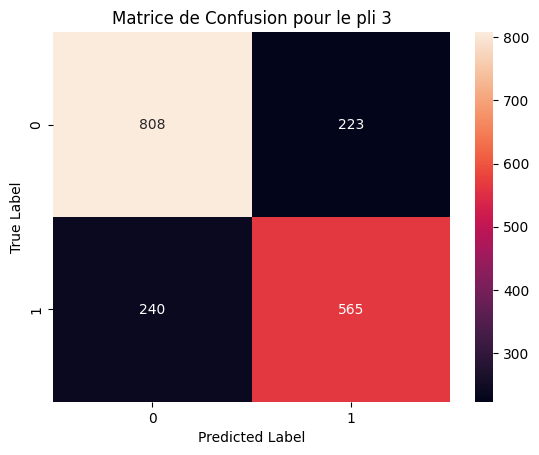

58/58 [==============================] - 0s 2ms/step


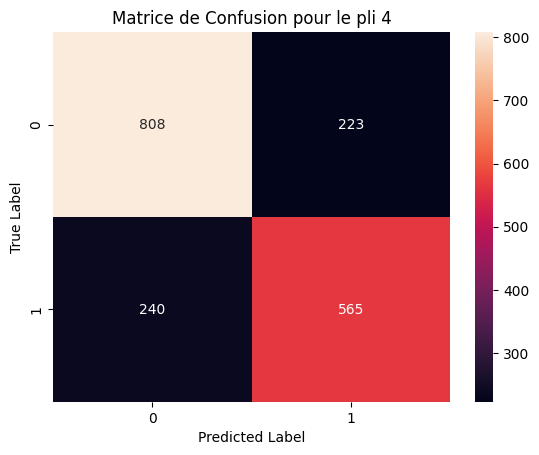

58/58 [==============================] - 0s 2ms/step


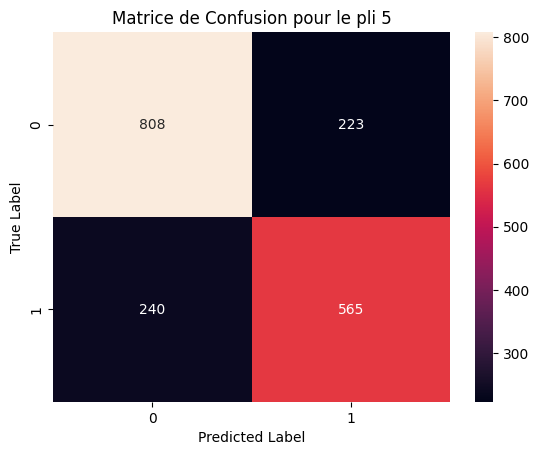

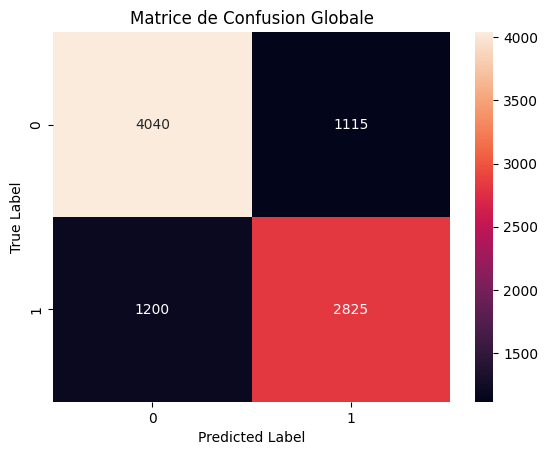

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assurez-vous que le chemin d'accès au fichier CSV est correct
y_train_path = 'Y_train_ofTdMHi.csv'
y_train_df = pd.read_csv(y_train_path)

# Convertissez la colonne 'pos_label' en chaîne de caractères si nécessaire
y_train_df['pos_label'] = y_train_df['pos_label'].astype(str)

# Liste des motifs désirés dans les noms de fichiers
desired_patterns = ['StMARTIN', 'StEUS', 'ARUBA', 'JAM']

# Compilation des motifs en une seule expression régulière
regex_pattern = '|'.join(desired_patterns)

# Filtrez le DataFrame pour ne conserver que les lignes correspondant aux motifs
# Vous devez ajuster la colonne sur laquelle vous voulez filtrer ('id' ou 'pos_label')
filtered_df = y_train_df[y_train_df['id'].str.contains(regex_pattern, case=False, na=False)]

# Chemin vers les fichiers audio et filtrage des fichiers
audio_dir = 'quatre_regions_audios/'

# Fonction pour créer des spectrogrammes à partir des fichiers audio
def create_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    spect = librosa.feature.melspectrogram(y=y, sr=sr)
    spect = librosa.power_to_db(spect, ref=np.max)
    spect = spect.astype(np.float32) # Pour compatibilité avec TensorFlow
    return spect

# Prétraitement des fichiers audio
def preprocess_data(y_train_df, audio_dir):
    X_spect = []
    y_labels = []

    # Traitement des fichiers dans l'ordre du dataframe
    for index, row in enumerate(y_train_df.itertuples(), 1):  # Commence l'indexation à 1
        audio_path = os.path.join(audio_dir, row.id)
        if os.path.isfile(audio_path):
            spect = create_spectrogram(audio_path)
            X_spect.append(spect)
            y_labels.append(row.pos_label)
            
            # Imprime un message tous les 20 spectrogrammes
            if index % 20 == 0:
                print(f"{index} spectrogrammes traités.")
        else:
            print(f"Le fichier {row.id} n'a pas été trouvé dans le répertoire.")
    
    X_spect = np.array(X_spect)
    X_spect = np.expand_dims(X_spect, axis=-1) # Ajout de la dimension de canal

    # Encodage des étiquettes
    y_labels = np.array(y_labels)
    le = LabelEncoder()
    y_labels_encoded = le.fit_transform(y_labels)
    y_categorical = to_categorical(y_labels_encoded)

    return X_spect, y_categorical


def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(2, 2), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Traitement des données
X_spect, y_categorical = preprocess_data(y_train_df, audio_dir)

import json

# Dictionnaire pour stocker les scores de chaque pli
scores = {}

# Validation croisée
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_spect, np.argmax(y_categorical, axis=1))):
    print(f'Début du pli {fold + 1}')
    X_train, X_val = X_spect[train_idx], X_spect[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    # Création du modèle pour le pli actuel
    model = create_cnn_model(X_train.shape[1:], y_categorical.shape[1])
    
    # Entraînement du modèle
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

    # Évaluation du modèle sur l'ensemble de validation
    score = model.evaluate(X_val, y_val, verbose=0)
    print(f'Résultats pour le pli {fold + 1}:')
    print(f'Test Loss: {score[0]}')
    print(f'Test Accuracy: {score[1]}')
    
    # Sauvegarde des métriques pour analyse
    scores[f'fold_{fold + 1}'] = {
        'loss': score[0],
        'accuracy': score[1]
    }

    # Sauvegarde des métriques d'entraînement pour analyse
    with open(f'training_history_fold_{fold + 1}.json', 'w') as f:
        json.dump(history.history, f)

# ... (le code précédent reste inchangé)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialisation d'une liste pour collecter les vraies étiquettes et les prédictions
true_labels = []
predicted_labels = []

# Validation croisée avec matrice de confusion
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_spect, np.argmax(y_categorical, axis=1))):
    # ... (le reste de la boucle de validation croisée reste inchangé)

    # Prédire les classes pour l'ensemble de validation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Ajouter les vraies étiquettes et les prédictions aux listes
    true_labels.extend(y_true_classes)
    predicted_labels.extend(y_pred_classes)

    # Calcul et affichage de la matrice de confusion pour le pli actuel
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Matrice de Confusion pour le pli {fold + 1}')
    plt.show()

# Générer la matrice de confusion globale pour tous les plis
cm_global = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm_global, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Matrice de Confusion Globale')
plt.show()

# Enregistrez le modèle après la validation croisée si vous souhaitez faire des prédictions ultérieurement
model.save('model_4r.h5')




In [20]:
import os
import numpy as np
import pandas as pd
import librosa
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Supposons que `model_path` est le chemin vers votre modèle entraîné
model = load_model('model_4r.h5')

# Ou utilisez le modèle déjà en mémoire si vous venez juste de l'entraîner.

# Fonction pour prétraiter les nouveaux extraits audio
def preprocess_new_audio(audio_dir):
    X_new = []
    file_names = []
    for file in os.listdir(audio_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(audio_dir, file)
            spect = create_spectrogram(file_path)
            X_new.append(spect)
            file_names.append(file)
    X_new = np.array(X_new)
    X_new = np.expand_dims(X_new, axis=-1)
    return X_new, file_names

# Fonction pour prédire et sauvegarder les résultats
def predict_and_save(model, audio_dir, le, output_csv_path):
    X_new, file_names = preprocess_new_audio(audio_dir)
    predictions = model.predict(X_new)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = le.inverse_transform(predicted_classes)

    # Création d'un DataFrame pour les résultats
    results_df = pd.DataFrame({
        'id': file_names,
        'pos_label': predicted_labels
    })

    # Enregistrez le DataFrame dans le format de 'Y_random.csv'
    results_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

# Emplacement de vos nouveaux extraits audio
new_audio_dir = 'extracted_audio_test/X_test/'

# Encoder pour les étiquettes utilisé pendant l'entraînement
le = LabelEncoder()
le.fit(y_train_df['pos_label'].unique())


# Chemin où le fichier CSV des prédictions sera enregistré
output_csv_path = 'predictions_cnn_4r.csv'

# Faire des prédictions et sauvegarder les résultats
predict_and_save(model, new_audio_dir, le, output_csv_path)


30/30 [==============================] - 0s 3ms/step
Predictions saved to predictions_cnn_4r.csv


## v4 nouveau spectro ternat
---

### code ternat

In [ ]:
import soundfile
import numpy as np
from scipy import signal
import librosa.feature as feat
import pandas as pd
import os
import librosa as lr
import librosa.display
import matplotlib.pyplot as plt

def spectrogramme(file, save_path):
    # Charger le fichier audio
    sig, sr = soundfile.read(file)

    # Calculer la STFT et convertir en magnitudes
    tf_sig = lr.stft(sig, n_fft=2048)
    tf_sig = np.abs(tf_sig)

    # Convertir en décibels
    spectrogram_db = lr.amplitude_to_db(tf_sig, ref=np.max)

    # Créer une figure pour le spectrogramme
    lr.display.specshow(spectrogram_db)

    # Enregistrer l'image du spectrogramme dans le dossier spécifié
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_file(file):
    if file.endswith('.wav'):
        file_path = os.path.join(audio_folder, file)
        save_path = os.path.join(save_folder, file[:-4] + '.png')
        print(f"Calling spectrogramme for: {file}")  # Debug - confirm function call
        spectrogramme(file_path, save_path)

audio_folder = 'data/X_train/'
save_folder = 'images/'

audio_files = [file for file in os.listdir(audio_folder) if (file.endswith('.wav') ]
print(f"Found {len(audio_files)} audio files.")  # Debug - confirm files found

for file in audio_files:
    process_file(file) 

### code global all   0.71

In [50]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Chemins vers les dossiers et fichiers
train_dir = 'images'
y_train_path = 'Y_train_ofTdMHi.csv'

# Charger les données d'entraînement
y_train_df = pd.read_csv(y_train_path)

# Conversion des identifiants et des labels
y_train_df['id'] = y_train_df['id'].apply(lambda x: x.replace('.wav', '.png'))
y_train_df['pos_label'] = y_train_df['pos_label'].astype(str)

# Séparation des données en ensemble d'entraînement et de validation
train_df, val_df = train_test_split(y_train_df, test_size=0.2, random_state=42)

# Générateur pour les données d'entraînement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='pos_label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Générateur pour les données de validation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='pos_label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

# Évaluation de l'accuracy sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

# Prédictions sur l'ensemble de validation pour la matrice de confusion
val_predictions = model.predict(val_generator)
val_preds_binary = (val_predictions > 0.5).astype(int)

# Vraies étiquettes de l'ensemble de validation
y_true = val_generator.classes

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, val_preds_binary)
print("Matrice de confusion :")
print(conf_matrix)

# Sauvegarde du modèle
model.save('nvcnn.h5')
print("Modèle sauvegardé sous 'mon_modele_cnn.h5'")


Found 18534 validated image filenames belonging to 2 classes.
Found 4634 validated image filenames belonging to 2 classes.
Epoch 1/50
580/580 [==============================] - 77s 131ms/step - loss: 0.4291 - accuracy: 0.7998 - val_loss: 0.2817 - val_accuracy: 0.8921
Epoch 2/50
580/580 [==============================] - 77s 132ms/step - loss: 0.2747 - accuracy: 0.8962 - val_loss: 0.2357 - val_accuracy: 0.9091
Epoch 3/50
580/580 [==============================] - 75s 130ms/step - loss: 0.2420 - accuracy: 0.9090 - val_loss: 0.2145 - val_accuracy: 0.9182
Epoch 4/50
580/580 [==============================] - 74s 128ms/step - loss: 0.2215 - accuracy: 0.9197 - val_loss: 0.2009 - val_accuracy: 0.9234
Epoch 5/50
580/580 [==============================] - 76s 131ms/step - loss: 0.2051 - accuracy: 0.9259 - val_loss: 0.1891 - val_accuracy: 0.9309
Epoch 6/50
580/580 [==============================] - 70s 120ms/step - loss: 0.1899 - accuracy: 0.9316 - val_loss: 0.1905 - val_accuracy: 0.9290
Epoch 7

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le modèle enregistré
model_path = 'nvcnn.h5'

# Charger le modèle
model = tf.keras.models.load_model(model_path)

# Chemin vers le dossier des images de test
test_dir = 'images_test/all'

# Charger les données de test
y_test_path = 'Y_random_Xwjr6aB.csv'
y_test_df = pd.read_csv(y_test_path)

# Adapter les noms des fichiers dans y_test_df pour qu'ils correspondent aux images
y_test_df['id'] = y_test_df['id'].apply(lambda x: x.replace('.wav', '.png'))

# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=y_test_df,
    directory=test_dir,
    x_col='id',
    target_size=(64, 64),  # Assurez-vous que cette taille correspond à celle utilisée lors de l'entraînement
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Prédire avec le modèle
predictions = model.predict(test_generator)

# Convertir les prédictions en étiquettes binaires
predicted_labels = (predictions > 0.5).astype(int)

# Créer le DataFrame pour le fichier CSV de sortie
output_df = pd.DataFrame({
    'id': y_test_df['id'].str.replace('.png', '.wav'),
    'label': predicted_labels.flatten()
})

# Chemin vers le fichier CSV de sortie
output_csv_path = 'predictions_nvcnn2.csv'

# Enregistrer le DataFrame en CSV
output_df.to_csv(output_csv_path, index=False)
print(f'Les prédictions ont été enregistrées dans {output_csv_path}')


Found 950 validated image filenames.
30/30 [==============================] - 3s 95ms/step
Les prédictions ont été enregistrées dans predictions_nvcnn2.csv


### Code 4r 0.70
---

In [52]:
import os
import shutil

# Définissez le chemin vers le dossier source et le dossier de destination
source_folder = 'images'  # Remplacez par le chemin de votre dossier source
destination_folder = 'quatre_regions_images'  # Remplacez par le chemin de votre dossier de destination

# Créez le dossier de destination s'il n'existe pas
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Définissez les chaînes de caractères que vous recherchez dans les titres des fichiers
patterns = ['StMARTIN', 'StEUS', 'ARUBA', 'JAM']

# Parcourez tous les fichiers dans le dossier source
for filename in os.listdir(source_folder):
    # Vérifiez si le nom du fichier contient l'une des chaînes de caractères spécifiées
    if any(pattern in filename for pattern in patterns):
        # Construisez le chemin complet vers les fichiers source et de destination
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        # Copiez le fichier dans le dossier de destination
        shutil.copy2(source_path, destination_path)

print(f'Les fichiers ont été copiés dans {destination_folder}')

Les fichiers ont été copiés dans quatre_regions_images


In [53]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Assurez-vous que le chemin d'accès au fichier CSV est correct
y_train_path = 'Y_train_ofTdMHi.csv'
y_train_df = pd.read_csv(y_train_path)

# Convertissez la colonne 'pos_label' en chaîne de caractères si nécessaire
y_train_df['id'] = y_train_df['id'].apply(lambda x: x.replace('.wav', '.png'))
y_train_df['pos_label'] = y_train_df['pos_label'].astype(str)

# Liste des motifs désirés dans les noms de fichiers
desired_patterns = ['StMARTIN', 'StEUS', 'ARUBA', 'JAM']

# Compilation des motifs en une seule expression régulière
regex_pattern = '|'.join(desired_patterns)

# Filtrez le DataFrame pour ne conserver que les lignes correspondant aux motifs
# Vous devez ajuster la colonne sur laquelle vous voulez filtrer ('id' ou 'pos_label')
y_train_df = y_train_df[y_train_df['id'].str.contains(regex_pattern, case=False, na=False)]

# Chemin vers les fichiers audio et filtrage des fichiers
audio_dir = 'quatre_regions_images/'

# Séparation des données en ensemble d'entraînement et de validation
train_df, val_df = train_test_split(y_train_df, test_size=0.2, random_state=53)

# Générateur pour les données d'entraînement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='pos_label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Générateur pour les données de validation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='pos_label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

# Évaluation de l'accuracy sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

# Prédictions sur l'ensemble de validation pour la matrice de confusion
val_predictions = model.predict(val_generator)
val_preds_binary = (val_predictions > 0.5).astype(int)


# Vraies étiquettes de l'ensemble de validation
y_true = val_generator.classes

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, val_preds_binary)
print("Matrice de confusion :")
print(conf_matrix)

# Sauvegarde du modèle
model.save('nvcnn_4r.h5')
print("Modèle sauvegardé sous 'mon_modele_cnn.h5'")


Found 7344 validated image filenames belonging to 2 classes.
Found 1837 validated image filenames belonging to 2 classes.
Epoch 1/50
230/230 [==============================] - 31s 129ms/step - loss: 0.5339 - accuracy: 0.7256 - val_loss: 0.3401 - val_accuracy: 0.8563
Epoch 2/50
230/230 [==============================] - 29s 128ms/step - loss: 0.3460 - accuracy: 0.8632 - val_loss: 0.2717 - val_accuracy: 0.8922
Epoch 3/50
230/230 [==============================] - 29s 127ms/step - loss: 0.2977 - accuracy: 0.8855 - val_loss: 0.2650 - val_accuracy: 0.8977
Epoch 4/50
230/230 [==============================] - 29s 127ms/step - loss: 0.2732 - accuracy: 0.8932 - val_loss: 0.2511 - val_accuracy: 0.8960
Epoch 5/50
230/230 [==============================] - 29s 128ms/step - loss: 0.2509 - accuracy: 0.9047 - val_loss: 0.2438 - val_accuracy: 0.9004
Epoch 6/50
230/230 [==============================] - 29s 127ms/step - loss: 0.2328 - accuracy: 0.9153 - val_loss: 0.2162 - val_accuracy: 0.9194
Epoch 7/

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le modèle enregistré
model_path = 'nvcnn_4r.h5'

# Charger le modèle
model = tf.keras.models.load_model(model_path)

# Chemin vers le dossier des images de test
test_dir = 'images_test/all'

# Charger les données de test
y_test_path = 'Y_random_Xwjr6aB.csv'
y_test_df = pd.read_csv(y_test_path)

# Adapter les noms des fichiers dans y_test_df pour qu'ils correspondent aux images
y_test_df['id'] = y_test_df['id'].apply(lambda x: x.replace('.wav', '.png'))

# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=y_test_df,
    directory=test_dir,
    x_col='id',
    target_size=(64, 64),  # Assurez-vous que cette taille correspond à celle utilisée lors de l'entraînement
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Prédire avec le modèle
predictions = model.predict(test_generator)

# Convertir les prédictions en étiquettes binaires
predicted_labels = (predictions > 0.5).astype(int)

# Créer le DataFrame pour le fichier CSV de sortie
output_df = pd.DataFrame({
    'id': y_test_df['id'].str.replace('.png', '.wav'),
    'label': predicted_labels.flatten()
})

# Chemin vers le fichier CSV de sortie
output_csv_path = 'predictions.csv'

# Enregistrer le DataFrame en CSV
output_df.to_csv(output_csv_path, index=False)
print(f'Les prédictions ont été enregistrées dans {output_csv_path}')


Found 950 validated image filenames.
30/30 [==============================] - 3s 91ms/step
Les prédictions ont été enregistrées dans predictions.csv


### v3 neurones on va voir 0.71/0.69
---

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the labels
labels_df = pd.read_csv('Y_train_ofTdMHi.csv')
labels_df['id'] = labels_df['id'].apply(lambda x: x.replace('.wav', '.png'))

# Load the images and associate them with labels
image_folder = 'images/'
images = []
labels = []
for index, row in labels_df.iterrows():
    image_path = os.path.join(image_folder, row['id'])
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
    image = tf.keras.preprocessing.image.img_to_array(image)
    images.append(image)
    labels.append(row['pos_label'])

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the pixel values
images = images / 255.0

# Encode the labels to one-hot vectors
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=53)

# Define the CNN architecture
# Define the CNN architecture with an additional convolutional layer
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'), # Nouvelle couche convolutive ajoutée ici
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.004), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Predictions for the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

# ... après l'entraînement ...

# Enregistrer le modèle pour une utilisation future
model.save('cnn_v3_neurones.h5')

# Pour charger le modèle plus tard :
# modele_charge = tf.keras.models.load_model('mon_modele_cnn.h5')



Epoch 1/50
464/464 [==============================] - 10s 20ms/step - loss: 0.4028 - accuracy: 0.8193 - val_loss: 0.2534 - val_accuracy: 0.9010
Epoch 2/50
464/464 [==============================] - 9s 20ms/step - loss: 0.2697 - accuracy: 0.9004 - val_loss: 0.2435 - val_accuracy: 0.9059
Epoch 3/50
464/464 [==============================] - 9s 20ms/step - loss: 0.2382 - accuracy: 0.9135 - val_loss: 0.2179 - val_accuracy: 0.9175
Epoch 4/50
464/464 [==============================] - 9s 20ms/step - loss: 0.2295 - accuracy: 0.9157 - val_loss: 0.2289 - val_accuracy: 0.9212
Epoch 5/50
464/464 [==============================] - 9s 20ms/step - loss: 0.2091 - accuracy: 0.9251 - val_loss: 0.2187 - val_accuracy: 0.9231
Epoch 6/50
464/464 [==============================] - 9s 20ms/step - loss: 0.1961 - accuracy: 0.9287 - val_loss: 0.2026 - val_accuracy: 0.9320
Epoch 7/50
464/464 [==============================] - 9s 20ms/step - loss: 0.1963 - accuracy: 0.9277 - val_loss: 0.2190 - val_accuracy: 0.918

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Charger le modèle entraîné
modele_charge = load_model('cnn_v3_neurones.h5')

# Répertoire contenant les nouvelles images
nouveau_dossier_images = 'images_test/all/'

# Préparer les nouvelles images
nouvelles_images = []
ids_images = []
for filename in os.listdir(nouveau_dossier_images):
    if filename.endswith('.png'):
        image_path = os.path.join(nouveau_dossier_images, filename)
        image = load_img(image_path, target_size=(64, 64))
        image = img_to_array(image)
        image = image / 255.0  # Normaliser l'image
        nouvelles_images.append(image)
        ids_images.append(filename.replace('.png', '.wav'))  # Assurer que l'ID correspond au format attendu

# Convertir la liste en numpy array pour la prédiction
nouvelles_images = np.array(nouvelles_images)

# Prédire les étiquettes des nouvelles images
predictions = modele_charge.predict(nouvelles_images)
classes_predites = np.argmax(predictions, axis=1)

# Charger les étiquettes depuis le fichier csv original pour obtenir la correspondance
etiquettes_originales = pd.read_csv('Y_random_Xwjr6aB.csv')
etiquettes = etiquettes_originales['pos_label'].unique()

# Associer les indices de classe prédits avec les étiquettes de classe réelles
etiquettes_predites = [etiquettes[i] for i in classes_predites]

# Créer le DataFrame pour les résultats
resultats = pd.DataFrame({'id': ids_images, 'etiquette_predite': etiquettes_predites})

# Sauvegarder les résultats dans un fichier CSV
resultats.to_csv('pred_cnn_v3.csv', index=False)


30/30 [==============================] - 0s 8ms/step


## v5 cluster knn/kmeans région + neurones par classe
---

### v1 sans matrice etc
---

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
import joblib
from tensorflow.keras.layers import Dense
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score

# Load the data
features_path = 'features_train.csv'
labels_path = 'Y_train_ofTdMHi.csv'
features = pd.read_csv(features_path)
labels = pd.read_csv(labels_path)

# Data Preparation
features['region'] = features['id'].str.extract(r'-(\D+).wav')
merged_data = pd.merge(features, labels, on='id', how='left')

# Encode the 'region' column to numeric values
le = LabelEncoder()
merged_data['region'] = le.fit_transform(merged_data['region'])

# KNN for Region Classification
X = merged_data.drop(['id', 'region', 'pos_label'], axis=1)
y_region = merged_data['region']

# Splitting the data
X_train, X_test, y_train_region, y_test_region = train_test_split(X, y_region, test_size=0.2, random_state=42)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_region)

# Save the KNN model
joblib.dump(knn, 'knn_model.joblib')

# Predict regions
predicted_regions = knn.predict(X_test)

# Building a simple neural network for each region
unique_regions = merged_data['region'].unique()
nn_models = {}

for region in unique_regions:
    # Filter data for the specific region
    region_data = merged_data[merged_data['region'] == region]
    
    # Neural network
    model = Sequential([
        Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Preparing data for training the neural network
    X_nn = region_data.drop(['id', 'region', 'pos_label'], axis=1)
    y_nn = region_data['pos_label']
    X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)
    
    # Train the neural network
    model.fit(X_nn_train, y_nn_train, epochs=10, batch_size=10)
    
    # Save the neural network model for the region
    model.save(f'nn_model_region_{region}.h5')
    nn_models[region] = model




Epoch 1/10


369/369 [==============================] - 3s 2ms/step - loss: 1617.1351 - accuracy: 0.6419
Epoch 2/10
369/369 [==============================] - 1s 2ms/step - loss: 62.2460 - accuracy: 0.7434
Epoch 3/10
369/369 [==============================] - 1s 2ms/step - loss: 49.8476 - accuracy: 0.7762
Epoch 4/10
369/369 [==============================] - 1s 2ms/step - loss: 44.3618 - accuracy: 0.7925
Epoch 5/10
369/369 [==============================] - 1s 2ms/step - loss: 40.7632 - accuracy: 0.7862
Epoch 6/10
369/369 [==============================] - 1s 2ms/step - loss: 38.9630 - accuracy: 0.7992
Epoch 7/10
369/369 [==============================] - 1s 2ms/step - loss: 35.4193 - accuracy: 0.8041
Epoch 8/10
369/369 [==============================] - 1s 4ms/step - loss: 31.5902 - accuracy: 0.8117
Epoch 9/10
369/369 [==============================] - 1s 3ms/step - loss: 32.0149 - accuracy: 0.8106
Epoch 10/10
369/369 [==============================] - 1s 2ms/step - loss: 27.5770 -

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
677/677 [==============================] - 3s 2ms/step - loss: 128.1852 - accuracy: 0.6682
Epoch 2/10
677/677 [==============================] - 1s 2ms/step - loss: 49.5395 - accuracy: 0.7806
Epoch 3/10
677/677 [==============================] - 1s 2ms/step - loss: 33.4108 - accuracy: 0.7980
Epoch 4/10
677/677 [==============================] - 1s 2ms/step - loss: 25.5445 - accuracy: 0.8030
Epoch 5/10
677/677 [==============================] - 2s 3ms/step - loss: 16.3289 - accuracy: 0.8129
Epoch 6/10
677/677 [==============================] - 1s 2ms/step - loss: 13.3598 - accuracy: 0.8184
Epoch 7/10
677/677 [==============================] - 1s 2ms/step - loss: 11.4060 - accuracy: 0.8317
Epoch 8/10
677/677 [==============================] - 1s 2ms/step - loss: 9.1094 - accuracy: 0.8351
Epoch 9/10
677/677 [==============================] - 1s 2ms/step - loss: 10.3564 - accuracy: 0.8302
Epoch 10/10
677/677 [==============================] - 1s 2ms/step - loss: 9.5699 - accurac

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
397/397 [==============================] - 2s 2ms/step - loss: 416.2825 - accuracy: 0.5287
Epoch 2/10
397/397 [==============================] - 1s 2ms/step - loss: 53.6956 - accuracy: 0.6195
Epoch 3/10
397/397 [==============================] - 1s 2ms/step - loss: 32.6868 - accuracy: 0.6496
Epoch 4/10
397/397 [==============================] - 1s 2ms/step - loss: 24.4915 - accuracy: 0.6819
Epoch 5/10
397/397 [==============================] - 1s 2ms/step - loss: 22.3780 - accuracy: 0.6943
Epoch 6/10
397/397 [==============================] - 1s 3ms/step - loss: 16.1313 - accuracy: 0.7253
Epoch 7/10
397/397 [==============================] - 1s 3ms/step - loss: 15.5665 - accuracy: 0.7296
Epoch 8/10
397/397 [==============================] - 1s 2ms/step - loss: 14.1850 - accuracy: 0.7362
Epoch 9/10
397/397 [==============================] - 1s 3ms/step - loss: 14.9879 - accuracy: 0.7331
Epoch 10/10
397/397 [==============================] - 1s 3ms/step - loss: 11.6778 - accur

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
233/233 [==============================] - 2s 4ms/step - loss: 6421.3857 - accuracy: 0.4882
Epoch 2/10
233/233 [==============================] - 1s 4ms/step - loss: 68.3889 - accuracy: 0.6700
Epoch 3/10
233/233 [==============================] - 1s 4ms/step - loss: 53.8292 - accuracy: 0.7436
Epoch 4/10
233/233 [==============================] - 1s 3ms/step - loss: 47.1145 - accuracy: 0.7445
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 45.4042 - accuracy: 0.7518
Epoch 6/10
233/233 [==============================] - 1s 2ms/step - loss: 51.8139 - accuracy: 0.7389
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 42.9462 - accuracy: 0.7475
Epoch 8/10
233/233 [==============================] - 1s 3ms/step - loss: 38.2338 - accuracy: 0.7669
Epoch 9/10
233/233 [==============================] - 1s 2ms/step - loss: 34.0092 - accuracy: 0.7738
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 34.2199 - accu

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 1s 3ms/step - loss: 7941.6001 - accuracy: 0.3793
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 2281.8542 - accuracy: 0.4009
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 455.2003 - accuracy: 0.6034
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 274.3519 - accuracy: 0.4957
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 257.8695 - accuracy: 0.5517
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 221.0513 - accuracy: 0.5474
Epoch 7/10
24/24 [==============================] - 0s 4ms/step - loss: 203.6822 - accuracy: 0.5216
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 178.5099 - accuracy: 0.5000
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 142.2032 - accuracy: 0.5129
Epoch 10/10
24/24 [==============================] - 0s 2ms/step - loss: 124.3932 - accuracy: 0.5517


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
66/66 [==============================] - 1s 2ms/step - loss: 3612.6077 - accuracy: 0.3282
Epoch 2/10
66/66 [==============================] - 0s 2ms/step - loss: 394.8712 - accuracy: 0.3819
Epoch 3/10
66/66 [==============================] - 0s 2ms/step - loss: 66.4606 - accuracy: 0.6411
Epoch 4/10
66/66 [==============================] - 0s 2ms/step - loss: 51.4645 - accuracy: 0.6227
Epoch 5/10
66/66 [==============================] - 0s 2ms/step - loss: 57.3440 - accuracy: 0.6672
Epoch 6/10
66/66 [==============================] - 0s 2ms/step - loss: 53.3583 - accuracy: 0.6411
Epoch 7/10
66/66 [==============================] - 0s 2ms/step - loss: 46.7694 - accuracy: 0.6549
Epoch 8/10
66/66 [==============================] - 0s 2ms/step - loss: 47.0900 - accuracy: 0.6564
Epoch 9/10
66/66 [==============================] - 0s 2ms/step - loss: 43.2410 - accuracy: 0.6319
Epoch 10/10
66/66 [==============================] - 0s 2ms/step - loss: 44.9344 - accuracy: 0.6488


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
69/69 [==============================] - 1s 2ms/step - loss: 656.8585 - accuracy: 0.8392
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 32.2872 - accuracy: 0.8918
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 24.1040 - accuracy: 0.9181
Epoch 4/10
69/69 [==============================] - 0s 2ms/step - loss: 16.7421 - accuracy: 0.9254
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 10.6211 - accuracy: 0.9284
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 6.8332 - accuracy: 0.9240
Epoch 7/10
69/69 [==============================] - 0s 2ms/step - loss: 9.0273 - accuracy: 0.9386
Epoch 8/10
69/69 [==============================] - 0s 2ms/step - loss: 14.3892 - accuracy: 0.9108
Epoch 9/10
69/69 [==============================] - 0s 2ms/step - loss: 7.8255 - accuracy: 0.9371
Epoch 10/10
69/69 [==============================] - 0s 2ms/step - loss: 8.3330 - accuracy: 0.9474
Epoch 1/10


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 1s 3ms/step - loss: 644.6580 - accuracy: 0.3333
Epoch 2/10
23/23 [==============================] - 0s 3ms/step - loss: 216.0791 - accuracy: 0.5000
Epoch 3/10
23/23 [==============================] - 0s 4ms/step - loss: 106.8133 - accuracy: 0.6447
Epoch 4/10
23/23 [==============================] - 0s 5ms/step - loss: 39.3997 - accuracy: 0.7851
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: 31.9190 - accuracy: 0.8246
Epoch 6/10
23/23 [==============================] - 0s 4ms/step - loss: 32.5887 - accuracy: 0.8070
Epoch 7/10
23/23 [==============================] - 0s 2ms/step - loss: 35.9686 - accuracy: 0.7939
Epoch 8/10
23/23 [==============================] - 0s 4ms/step - loss: 30.1719 - accuracy: 0.8246
Epoch 9/10
23/23 [==============================] - 0s 3ms/step - loss: 32.2435 - accuracy: 0.8509
Epoch 10/10
23/23 [==============================] - 0s 3ms/step - loss: 34.5250 - accuracy: 0.8158


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# Load the test data
test_features_path = 'features_test.csv'
test_features = pd.read_csv(test_features_path)

# Load the saved KNN model
knn_model = joblib.load('knn_model.joblib')

# Preprocess the Test Data
# Assuming you need to extract region or any preprocessing as done with the training data
test_features['region'] = test_features['id'].str.extract(r'-(\D+).wav')

# Predict Regions using KNN
X_test = test_features.drop(['id', 'region'], axis=1)  # or whatever features the KNN model was trained on
predicted_regions = knn_model.predict(X_test)

# ... [previous code]

# Load each neural network model and make predictions
results = []
for index, feature in test_features.iterrows():
    region = predicted_regions[index]  # the predicted region for this feature
    nn_model = load_model(f'nn_model_region_{region}.h5')  # load the model for the specific region
    
    # Prepare the feature data for prediction
    # Make sure to select the features in the same order as the training and convert to float32
    feature_values = feature.drop(['id', 'region']).values.astype('float32').reshape(1, -1)
    
    # Make a prediction using the neural network
    signal_prediction = nn_model.predict(feature_values)
    
    # Assuming a binary classification (0 or 1)
    binary_signal = 1 if signal_prediction >= 0.5 else 0
    
    results.append({
        'id': feature['id'],
        'pos_label': binary_signal
    })

# ... [rest of the code]


# Convert results to DataFrame and save it similar to Y_random.csv
predicted_df = pd.DataFrame(results)
predicted_df.to_csv('knn_v1.csv', index=False)

# Replace 'path/to/features_test.csv' with the actual path to your test CSV file.


1/1 [==============================] - 0s 96ms/step


### v2 avec matrice et accuracy globale      0.60
---

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score

# Load the data
features_path = 'features_train.csv'
labels_path = 'Y_train_ofTdMHi.csv'
features = pd.read_csv(features_path)
labels = pd.read_csv(labels_path)

# Data Preparation
features['region'] = features['id'].str.extract(r'-(\D+).wav')
merged_data = pd.merge(features, labels, on='id', how='left')

# Encode the 'region' column to numeric values
le = LabelEncoder()
merged_data['region_encoded'] = le.fit_transform(merged_data['region'])

# KNN for Region Classification
X = merged_data.drop(['id', 'region', 'pos_label', 'region_encoded'], axis=1)
y_region = merged_data['region_encoded']

# Splitting the data
X_train, X_test, y_train_region, y_test_region = train_test_split(X, y_region, test_size=0.2, random_state=42)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_region)

# Save the KNN model
joblib.dump(knn, 'knn_model_v2.joblib')

# Predict regions
predicted_regions = knn.predict(X_test)

# Evaluate and print the KNN classifier's confusion matrix and accuracy
cm_knn = confusion_matrix(y_test_region, predicted_regions)
accuracy_knn = accuracy_score(y_test_region, predicted_regions)
print('Confusion Matrix for KNN Classifier:')
print(cm_knn)
print('Overall Accuracy for KNN Classifier:', accuracy_knn)

# Building and evaluating a simple neural network for each region
unique_regions = merged_data['region'].unique()
nn_models = {}
true_labels = []
predicted_labels = []

for region in unique_regions:
    # Filter data for the specific region
    region_data = merged_data[merged_data['region'] == region]
    
    # Neural network
    model = Sequential([
        Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Preparing data for training the neural network
    X_nn = region_data.drop(['id', 'region', 'pos_label', 'region_encoded'], axis=1)
    y_nn = region_data['pos_label']
    X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)
    
    # Train the neural network
    model.fit(X_nn_train, y_nn_train, epochs=10, batch_size=10)
    
    # Save the neural network model for the region
    model.save(f'nn_model_region_{region}_v2.h5')
    nn_models[region] = model
    
    # Predict and evaluate the neural network
    y_pred_nn = (model.predict(X_nn_test) > 0.5).astype('int32').flatten()
    true_labels.extend(y_nn_test)
    predicted_labels.extend(y_pred_nn)

# Calculate and print the global confusion matrix and accuracy for neural networks
cm_nn = confusion_matrix(true_labels, predicted_labels)
accuracy_nn = accuracy_score(true_labels, predicted_labels)
print('Confusion Matrix for Neural Networks:')
print(cm_nn)
print('Overall Accuracy for Neural Networks:', accuracy_nn)


Confusion Matrix for KNN Classifier:
[[ 112    0    0    3   26   21    3   11]
 [   0   23    0   13    5   15    5    0]
 [   0    0   54    1    0    0    0    0]
 [   3    8    0  817   95   40    9    3]
 [  33    0    0   46 1502   47   10   51]
 [  18    2    0   39   80  401    4   20]
 [   0    4    0   30   59   19   62    1]
 [  23    1    2   12   90   23    1  787]]
Overall Accuracy for KNN Classifier: 0.8109624514458351
Epoch 1/10
369/369 [==============================] - 2s 2ms/step - loss: 212.1305 - accuracy: 0.4598
Epoch 2/10
369/369 [==============================] - 1s 2ms/step - loss: 59.5732 - accuracy: 0.6706
Epoch 3/10
369/369 [==============================] - 1s 2ms/step - loss: 31.5222 - accuracy: 0.7566
Epoch 4/10
369/369 [==============================] - 1s 2ms/step - loss: 25.0296 - accuracy: 0.7925
Epoch 5/10
369/369 [==============================] - 1s 2ms/step - loss: 21.3451 - accuracy: 0.8068
Epoch 6/10
369/369 [==============================] - 1s

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 2ms/step
Epoch 1/10
677/677 [==============================] - 3s 3ms/step - loss: 528.7506 - accuracy: 0.7537
Epoch 2/10
677/677 [==============================] - 1s 2ms/step - loss: 43.7418 - accuracy: 0.8020
Epoch 3/10
677/677 [==============================] - 1s 2ms/step - loss: 26.2726 - accuracy: 0.8029
Epoch 4/10
677/677 [==============================] - 1s 2ms/step - loss: 16.5200 - accuracy: 0.8061
Epoch 5/10
677/677 [==============================] - 1s 2ms/step - loss: 11.5022 - accuracy: 0.8138
Epoch 6/10
677/677 [==============================] - 1s 2ms/step - loss: 8.1725 - accuracy: 0.8154
Epoch 7/10
677/677 [==============================] - 1s 2ms/step - loss: 5.6580 - accuracy: 0.8216
Epoch 8/10
677/677 [==============================] - 1s 2ms/step - loss: 3.8421 - accuracy: 0.8306
Epoch 9/10
677/677 [==============================] - 1s 2ms/step - loss: 2.8106 - accuracy: 0.8270
Epoch 10/10
 1/53 [......................

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 0s 2ms/step
Epoch 1/10
397/397 [==============================] - 2s 2ms/step - loss: 106.8704 - accuracy: 0.6009
Epoch 2/10
397/397 [==============================] - 1s 2ms/step - loss: 36.3254 - accuracy: 0.7066
Epoch 3/10
397/397 [==============================] - 1s 2ms/step - loss: 28.8710 - accuracy: 0.7155
Epoch 4/10
397/397 [==============================] - 1s 2ms/step - loss: 16.6430 - accuracy: 0.7435
Epoch 5/10
397/397 [==============================] - 1s 2ms/step - loss: 11.4051 - accuracy: 0.7470
Epoch 6/10
397/397 [==============================] - 1s 2ms/step - loss: 7.7952 - accuracy: 0.7604
Epoch 7/10
397/397 [==============================] - 1s 2ms/step - loss: 5.0004 - accuracy: 0.7746
Epoch 8/10
397/397 [==============================] - 1s 2ms/step - loss: 6.0893 - accuracy: 0.7561
Epoch 9/10
397/397 [==============================] - 1s 2ms/step - loss: 4.5786 - accuracy: 0.7604
Epoch 10/10
397/397 [====================

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 2ms/step
Epoch 1/10
233/233 [==============================] - 2s 2ms/step - loss: 119.0715 - accuracy: 0.4851
Epoch 2/10
233/233 [==============================] - 1s 2ms/step - loss: 34.2344 - accuracy: 0.6290
Epoch 3/10
233/233 [==============================] - 1s 2ms/step - loss: 26.6071 - accuracy: 0.6958
Epoch 4/10
233/233 [==============================] - 0s 2ms/step - loss: 19.5057 - accuracy: 0.7126
Epoch 5/10
233/233 [==============================] - 1s 2ms/step - loss: 18.2304 - accuracy: 0.7113
Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 15.2874 - accuracy: 0.7290
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 11.6989 - accuracy: 0.7462
Epoch 8/10
233/233 [==============================] - 1s 2ms/step - loss: 10.8786 - accuracy: 0.7505
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 12.1358 - accuracy: 0.7428
Epoch 10/10
 1/19 [>.................

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 0s 2ms/step
Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 1092.4685 - accuracy: 0.6207
Epoch 2/10
24/24 [==============================] - 0s 2ms/step - loss: 130.7529 - accuracy: 0.5431
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 32.5469 - accuracy: 0.7155
Epoch 4/10
24/24 [==============================] - 0s 2ms/step - loss: 15.9701 - accuracy: 0.8017
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 19.6821 - accuracy: 0.7845
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 15.7581 - accuracy: 0.8017
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 10.9947 - accuracy: 0.8017
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 10.3744 - accuracy: 0.8147
Epoch 9/10
24/24 [==============================] - 0s 2ms/step - loss: 14.0912 - accuracy: 0.8190
Epoch 10/10
2/2 [==============================] - 0s

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
66/66 [==============================] - 2s 4ms/step - loss: 221.8671 - accuracy: 0.6626
Epoch 2/10
66/66 [==============================] - 0s 5ms/step - loss: 126.2664 - accuracy: 0.6902
Epoch 3/10
66/66 [==============================] - 0s 5ms/step - loss: 97.6050 - accuracy: 0.6764
Epoch 4/10
66/66 [==============================] - 0s 4ms/step - loss: 99.8112 - accuracy: 0.6610
Epoch 5/10
66/66 [==============================] - 0s 4ms/step - loss: 71.5540 - accuracy: 0.6626
Epoch 6/10
66/66 [==============================] - 0s 2ms/step - loss: 54.2966 - accuracy: 0.6411
Epoch 7/10
66/66 [==============================] - 0s 3ms/step - loss: 53.1005 - accuracy: 0.6258
Epoch 8/10
66/66 [==============================] - 0s 3ms/step - loss: 49.4141 - accuracy: 0.6304
Epoch 9/10
66/66 [==============================] - 0s 3ms/step - loss: 43.2009 - accuracy: 0.6135
Epoch 10/10
66/66 [==============================] - 0s 4ms/step - loss: 36.9405 - accuracy: 0.6120


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 5ms/step
Epoch 1/10
69/69 [==============================] - 1s 3ms/step - loss: 73.1945 - accuracy: 0.9035
Epoch 2/10
69/69 [==============================] - 0s 4ms/step - loss: 7.5374 - accuracy: 0.9474
Epoch 3/10
69/69 [==============================] - 0s 4ms/step - loss: 7.1935 - accuracy: 0.9459
Epoch 4/10
69/69 [==============================] - 0s 4ms/step - loss: 7.7681 - accuracy: 0.9430
Epoch 5/10
69/69 [==============================] - 0s 4ms/step - loss: 11.9226 - accuracy: 0.9576
Epoch 6/10
69/69 [==============================] - 0s 4ms/step - loss: 6.4250 - accuracy: 0.9518
Epoch 7/10
69/69 [==============================] - 0s 4ms/step - loss: 6.5204 - accuracy: 0.9620
Epoch 8/10
69/69 [==============================] - 0s 4ms/step - loss: 6.5881 - accuracy: 0.9503
Epoch 9/10
69/69 [==============================] - 0s 3ms/step - loss: 6.8041 - accuracy: 0.9488
Epoch 10/10
69/69 [==============================] - 0s 5ms/step 

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 3ms/step
Epoch 1/10
23/23 [==============================] - 1s 3ms/step - loss: 414.3888 - accuracy: 0.6447
Epoch 2/10
23/23 [==============================] - 0s 3ms/step - loss: 48.7086 - accuracy: 0.7412
Epoch 3/10
23/23 [==============================] - 0s 3ms/step - loss: 1.3594 - accuracy: 0.8640
Epoch 4/10
23/23 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.8596
Epoch 5/10
23/23 [==============================] - 0s 3ms/step - loss: 0.5097 - accuracy: 0.8640
Epoch 6/10
23/23 [==============================] - 0s 3ms/step - loss: 0.4305 - accuracy: 0.8596
Epoch 7/10
23/23 [==============================] - 0s 3ms/step - loss: 0.3876 - accuracy: 0.8640
Epoch 8/10
23/23 [==============================] - 0s 3ms/step - loss: 0.3349 - accuracy: 0.8640
Epoch 9/10
23/23 [==============================] - 0s 3ms/step - loss: 0.3261 - accuracy: 0.8684
Epoch 10/10
23/23 [==============================] - 0s 2ms/step

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 8ms/step
Confusion Matrix for Neural Networks:
[[2293  426]
 [ 350 1568]]
Overall Accuracy for Neural Networks: 0.8326504205305154


In [12]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
import os

# Load the test data
test_features_path = 'features_test.csv'
test_features = pd.read_csv(test_features_path)

# Load the saved KNN model
knn_model = joblib.load('knn_model_v2.joblib')

# Preprocess the Test Data
# Assuming you need to extract region or any preprocessing as done with the training data
test_features['region'] = test_features['id'].str.extract(r'-(\D+).wav')

# Predict Regions using KNN
X_test = test_features.drop(['id', 'region'], axis=1)  # or whatever features the KNN model was trained on
predicted_regions = knn_model.predict(X_test)

# ... [previous code]

# Load each neural network model and make predictions
# ... [previous code]

# Load each neural network model and make predictions
results = []
for index, feature in test_features.iterrows():
    # The predicted region's encoded value
    region_encoded = predicted_regions[index]  
    # Get the actual region name using the inverse transform method of the label encoder
    region_name = le.inverse_transform([region_encoded])[0]
    # Format the model filename to match the saved model file names
    model_filename = f'nn_model_region_{region_name.upper()}_v2.h5'
    
    if not os.path.exists(model_filename):
        print(f"Model file not found: {model_filename}")
        continue
    
    nn_model = load_model(model_filename)  # load the model for the specific region
    
    # ... [rest of the prediction code]

    feature_values = feature.drop(['id', 'region']).values.astype('float32').reshape(1, -1)
    
    # Make a prediction using the neural network
    signal_prediction = nn_model.predict(feature_values)
    
    # Assuming a binary classification (0 or 1)
    binary_signal = 1 if signal_prediction >= 0.5 else 0
    
    results.append({
        'id': feature['id'],
        'pos_label': binary_signal
    })

# ... [rest of the code]


# Convert results to DataFrame and save it similar to Y_random.csv
predicted_df = pd.DataFrame(results)
predicted_df.to_csv('knn_v2.csv', index=False)

# Replace 'path/to/features_test.csv' with the actual path to your test CSV file.


1/1 [==============================] - 0s 178ms/step


### v3 avec kmeans      0.71
---

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model
import os

# Load the training data
features_path = 'features_train.csv'
labels_path = 'Y_train_ofTdMHi.csv'
features = pd.read_csv(features_path)
labels = pd.read_csv(labels_path)

# Data Preparation
features['region'] = features['id'].str.extract(r'-(\D+).wav')
merged_data = pd.merge(features, labels, on='id', how='left')

# Encode the 'region' column to numeric values
le = LabelEncoder()
merged_data['region_encoded'] = le.fit_transform(merged_data['region'])

# Assuming you know the number of unique regions (clusters) beforehand
number_of_regions = len(merged_data['region'].unique())

# Features for clustering
X = merged_data.drop(['id', 'region', 'pos_label', 'region_encoded'], axis=1)

# KMeans Clustering
kmeans = KMeans(n_clusters=number_of_regions, random_state=42)
kmeans.fit(X)

# Assign clusters to each data point
clusters = kmeans.predict(X)
merged_data['cluster'] = clusters

# Save the KMeans model
joblib.dump(kmeans, 'kmeans_model_v3.joblib')

# Save the LabelEncoder
joblib.dump(le, 'label_encoder_v3.joblib')

# Building and training a simple neural network for each cluster
nn_models = {}
for cluster_label in range(number_of_regions):
    # Filter data for the specific cluster
    cluster_data = merged_data[merged_data['cluster'] == cluster_label]
    
    # Define the neural network model
    model = Sequential([
        Dense(10, activation='relu', input_shape=(X.shape[1],)),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Prepare data for training the neural network
    X_nn = cluster_data.drop(['id', 'region', 'pos_label', 'region_encoded', 'cluster'], axis=1)
    y_nn = cluster_data['pos_label']
    X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=53)
    
    # Train the model
    model.fit(X_nn_train, y_nn_train, epochs=10, batch_size=10)
    
    # Save the neural network model for the cluster
    model_filename = f'nn_model_cluster_{cluster_label}_v3.h5'
    model.save(model_filename)
    nn_models[cluster_label] = model

# Load the saved KMeans model and LabelEncoder
kmeans_loaded = joblib.load('kmeans_model_v3.joblib')
le_loaded = joblib.load('label_encoder_v3.joblib')

# Load new data for prediction
new_data_path = 'features_test.csv'
new_data = pd.read_csv(new_data_path)

# Preprocess the new data as needed (make sure to replicate preprocessing steps)
new_data['region'] = new_data['id'].str.extract(r'-(\D+).wav')

# It's important that the new data undergoes the same preprocessing as the training data.
# For example, if you encoded or transformed any features, you need to do that here too.
# ...

# Prepare the data for prediction by dropping the same columns as during training
X_new = new_data.drop(['id', 'region'], axis=1)

# Predict the clusters for the new data using the loaded KMeans model
new_data_clusters = kmeans_loaded.predict(X_new)

# Load the neural network model for each cluster and make predictions
new_data_results = []
import numpy as np

# ...

for index, data_point in new_data.iterrows():
    cluster_label = new_data_clusters[index]
    model_filename = f'nn_model_cluster_{cluster_label}_v3.h5'

    # Ensure the model file exists before trying to load it
    if os.path.exists(model_filename):
        nn_model_loaded = load_model(model_filename)
        
        # Drop 'id' and 'region' from the data point, convert to float32, and reshape for prediction
        data_point_preprocessed = data_point.drop(['id', 'region']).astype(np.float32).values.reshape(1, -1)
        
        # Make the prediction
        prediction = nn_model_loaded.predict(data_point_preprocessed)
        binary_signal = int(prediction > 0.5)
    else:
        print(f"Model file not found: {model_filename}")
        binary_signal = None

    new_data_results.append({
        'id': data_point['id'],
        'cluster': cluster_label,
        'pos_label': binary_signal
    })

# ...


# Convert the prediction results to a DataFrame and save them
predicted_df = pd.DataFrame(new_data_results)
predicted_df.to_csv('kmeans_v3.csv', index=False)


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/10
328/328 [==============================] - 2s 2ms/step - loss: 156.0001 - accuracy: 0.7544
Epoch 2/10
328/328 [==============================] - 1s 2ms/step - loss: 58.2789 - accuracy: 0.7757
Epoch 3/10
328/328 [==============================] - 1s 2ms/step - loss: 49.1143 - accuracy: 0.7736
Epoch 4/10
328/328 [==============================] - 1s 2ms/step - loss: 46.7207 - accuracy: 0.7806
Epoch 5/10
328/328 [==============================] - 1s 2ms/step - loss: 45.2673 - accuracy: 0.7736
Epoch 6/10
328/328 [==============================] - 1s 2ms/step - loss: 39.6127 - accuracy: 0.7809
Epoch 7/10
328/328 [==============================] - 1s 2ms/step - loss: 34.6055 - accuracy: 0.7861
Epoch 8/10
328/328 [==============================] - 1s 2ms/step - loss: 29.0907 - accuracy: 0.7977
Epoch 9/10
328/328 [==============================] - 1s 2ms/step - loss: 29.6698 - accuracy: 0.7916
Epoch 10/10
328/328 [==============================] - 1s 2ms/step - loss: 29.8788 - accur

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


345/345 [==============================] - 2s 2ms/step - loss: 311.8661 - accuracy: 0.7902
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 37.8181 - accuracy: 0.7998
Epoch 3/10
345/345 [==============================] - 1s 2ms/step - loss: 30.3978 - accuracy: 0.7987
Epoch 4/10
345/345 [==============================] - 1s 2ms/step - loss: 26.0811 - accuracy: 0.7958
Epoch 5/10
345/345 [==============================] - 1s 2ms/step - loss: 28.0833 - accuracy: 0.7769
Epoch 6/10
345/345 [==============================] - 1s 2ms/step - loss: 30.5219 - accuracy: 0.7807
Epoch 7/10
345/345 [==============================] - 1s 2ms/step - loss: 27.8036 - accuracy: 0.7911
Epoch 8/10
345/345 [==============================] - 1s 2ms/step - loss: 24.8985 - accuracy: 0.7902
Epoch 9/10
345/345 [==============================] - 1s 2ms/step - loss: 31.8310 - accuracy: 0.7719
Epoch 10/10
345/345 [==============================] - 1s 2ms/step - loss: 20.1160 - accuracy: 0.8074

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 1s 2ms/step - loss: 164.3376 - accuracy: 0.8201
Epoch 2/10
163/163 [==============================] - 0s 2ms/step - loss: 76.4326 - accuracy: 0.8552
Epoch 3/10
163/163 [==============================] - 0s 2ms/step - loss: 46.8086 - accuracy: 0.8608
Epoch 4/10
163/163 [==============================] - 0s 2ms/step - loss: 35.7344 - accuracy: 0.8762
Epoch 5/10
163/163 [==============================] - 0s 2ms/step - loss: 26.1409 - accuracy: 0.8866
Epoch 6/10
163/163 [==============================] - 0s 2ms/step - loss: 33.2076 - accuracy: 0.8909
Epoch 7/10
163/163 [==============================] - 0s 2ms/step - loss: 21.1580 - accuracy: 0.9063
Epoch 8/10
163/163 [==============================] - 0s 2ms/step - loss: 15.3713 - accuracy: 0.9100
Epoch 9/10
163/163 [==============================] - 0s 2ms/step - loss: 18.1168 - accuracy: 0.8996
Epoch 10/10
163/163 [==============================] - 0s 2ms/step - loss: 16.7175 - accuracy: 0.9150

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


581/581 [==============================] - 2s 2ms/step - loss: 187.8141 - accuracy: 0.6245
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 8.5189 - accuracy: 0.6383
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 9.4814 - accuracy: 0.6403
Epoch 4/10
581/581 [==============================] - 1s 2ms/step - loss: 6.8559 - accuracy: 0.6524
Epoch 5/10
581/581 [==============================] - 1s 2ms/step - loss: 4.4014 - accuracy: 0.6484
Epoch 6/10
581/581 [==============================] - 1s 2ms/step - loss: 3.2188 - accuracy: 0.6465
Epoch 7/10
581/581 [==============================] - 1s 2ms/step - loss: 2.4353 - accuracy: 0.6489
Epoch 8/10
581/581 [==============================] - 1s 2ms/step - loss: 1.0640 - accuracy: 0.6563
Epoch 9/10
581/581 [==============================] - 1s 2ms/step - loss: 0.7719 - accuracy: 0.6842
Epoch 10/10
581/581 [==============================] - 1s 2ms/step - loss: 0.6086 - accuracy: 0.7264
Epoch 1/

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 1s 2ms/step - loss: 389.9854 - accuracy: 0.6280
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 79.5629 - accuracy: 0.7167
Epoch 3/10
30/30 [==============================] - 0s 2ms/step - loss: 42.9369 - accuracy: 0.7543
Epoch 4/10
30/30 [==============================] - 0s 2ms/step - loss: 26.9760 - accuracy: 0.8771
Epoch 5/10
30/30 [==============================] - 0s 2ms/step - loss: 15.4765 - accuracy: 0.8908
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 14.3633 - accuracy: 0.9078
Epoch 7/10
30/30 [==============================] - 0s 2ms/step - loss: 12.8925 - accuracy: 0.9010
Epoch 8/10
30/30 [==============================] - 0s 2ms/step - loss: 13.9539 - accuracy: 0.9147
Epoch 9/10
30/30 [==============================] - 0s 2ms/step - loss: 11.6805 - accuracy: 0.9078
Epoch 10/10
30/30 [==============================] - 0s 2ms/step - loss: 11.0132 - accuracy: 0.9147
Epoch 1/10


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 1s 2ms/step - loss: 836.3034 - accuracy: 0.5312
Epoch 2/10
93/93 [==============================] - 0s 2ms/step - loss: 343.2722 - accuracy: 0.6261
Epoch 3/10
93/93 [==============================] - 0s 2ms/step - loss: 222.7902 - accuracy: 0.6864
Epoch 4/10
93/93 [==============================] - 0s 2ms/step - loss: 168.3356 - accuracy: 0.7284
Epoch 5/10
93/93 [==============================] - 0s 2ms/step - loss: 112.3397 - accuracy: 0.7737
Epoch 6/10
93/93 [==============================] - 0s 2ms/step - loss: 81.6873 - accuracy: 0.8060
Epoch 7/10
93/93 [==============================] - 0s 2ms/step - loss: 63.6832 - accuracy: 0.8384
Epoch 8/10
93/93 [==============================] - 0s 2ms/step - loss: 52.1150 - accuracy: 0.8578
Epoch 9/10
93/93 [==============================] - 0s 2ms/step - loss: 48.6350 - accuracy: 0.8642
Epoch 10/10
93/93 [==============================] - 0s 2ms/step - loss: 43.0140 - accuracy: 0.8879
Epoch 1/10


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/310 [==============================] - 1s 2ms/step - loss: 129.0597 - accuracy: 0.6418
Epoch 2/10
310/310 [==============================] - 1s 2ms/step - loss: 29.7449 - accuracy: 0.6735
Epoch 3/10
310/310 [==============================] - 1s 2ms/step - loss: 10.3192 - accuracy: 0.7346
Epoch 4/10
310/310 [==============================] - 1s 2ms/step - loss: 7.4189 - accuracy: 0.7430
Epoch 5/10
310/310 [==============================] - 0s 2ms/step - loss: 6.1209 - accuracy: 0.7656
Epoch 6/10
310/310 [==============================] - 0s 2ms/step - loss: 4.7170 - accuracy: 0.7743
Epoch 7/10
310/310 [==============================] - 0s 2ms/step - loss: 4.2729 - accuracy: 0.7740
Epoch 8/10
310/310 [==============================] - 0s 2ms/step - loss: 3.2849 - accuracy: 0.7850
Epoch 9/10
310/310 [==============================] - 0s 2ms/step - loss: 2.8348 - accuracy: 0.7792
Epoch 10/10
310/310 [==============================] - 0s 2ms/step - loss: 2.8825 - accuracy: 0.7695
Epoch 

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 2ms/step - loss: 4221.6846 - accuracy: 0.1000
Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 2806.4358 - accuracy: 0.1143
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 1603.2719 - accuracy: 0.2429
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 780.3468 - accuracy: 0.4000
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 405.9535 - accuracy: 0.5857
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 284.5794 - accuracy: 0.8000
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 284.2634 - accuracy: 0.8429
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 294.0765 - accuracy: 0.8571
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 286.3368 - accuracy: 0.8429
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 273.8098 - accuracy: 0.8286


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 108ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 65ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 143ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 105ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 66ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 123ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 109ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 147ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 119ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 118ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 106ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 107ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 86ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 96ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 153ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 146ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 104ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 67ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 58ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 99ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 133ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 105ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 119ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 119ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 114ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 100ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 102ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 134ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 135ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 121ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 131ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 112ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 96ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 100ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 127ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 111ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 119ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 101ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 55ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 113ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 67ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 104ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 96ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 106ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 107ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 66ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 67ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 112ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 95ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 88ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 111ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 88ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 102ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 85ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 66ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 127ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 112ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 125ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 92ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 102ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 114ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 107ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 74ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 65ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 55ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 54ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 107ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 134ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 86ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 110ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 113ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 81ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 109ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 54ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 58ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 102ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 95ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 114ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 107ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 131ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 105ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 101ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 121ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 96ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 85ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 85ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 113ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 107ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 96ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 115ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 114ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 105ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 102ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 121ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 101ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 138ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 99ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 80ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 99ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 107ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 116ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 86ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 104ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 111ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 99ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 81ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 95ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 111ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 86ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 65ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 74ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 74ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 81ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 121ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 73ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 94ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 127ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 133ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 74ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 118ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 95ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 119ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 104ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 101ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 144ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 135ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 150ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 131ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 105ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 124ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 118ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 87ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 117ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 125ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 122ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 1s 761ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 117ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 65ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 101ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 59ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 131ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 74ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 105ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 127ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 112ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 58ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 54ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 96ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 86ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 66ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 80ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 111ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 60ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 55ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 88ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 116ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 96ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 143ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 110ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 103ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 86ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 104ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 85ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 125ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 73ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 131ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 104ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 60ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 74ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 54ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 141ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 102ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 112ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 66ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 110ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 54ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 53ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 117ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 67ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 74ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 116ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 88ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 109ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 59ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 112ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 106ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 106ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 99ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 114ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 99ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 80ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 59ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 105ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 119ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 101ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 117ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 114ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 58ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 108ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 65ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 78ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 111ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 110ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 67ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 113ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 88ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 85ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 60ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 112ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 111ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 71ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 91ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 118ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 97ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 49ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 90ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 142ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 85ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 56ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 66ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 109ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 55ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 55ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 55ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 93ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 110ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 101ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 70ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 72ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 79ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 54ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 118ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 89ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 104ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 75ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 95ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 84ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 88ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 100ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 57ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 116ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 82ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 64ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 83ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 54ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 61ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 63ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 68ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 118ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 95ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 69ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 76ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 98ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)
C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 77ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - ETA: 0s

C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


1/1 [==============================] - 0s 62ms/step


C:\Users\rpaul\AppData\Local\Temp\ipykernel_21648\2545545578.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binary_signal = int(prediction > 0.5)


In [6]:
import pandas as pd

# Load the DataFrame from the CSV file
kmeans_v3 = pd.read_csv('kmeans_v3.csv')

# Drop the 'cluster' column from the DataFrame
kmeans_v3.drop(['cluster'], axis=1, inplace=True)

# Display the first few rows to verify the column is dropped
print(kmeans_v3.head())

# Save the modified DataFrame back to a CSV file
kmeans_v3.to_csv('kmeans_v3_no_cluster.csv', index=False)


               id  pos_label
0  23360-TEST.wav          1
1  23361-TEST.wav          1
2  23958-TEST.wav          1
3  23959-TEST.wav          1
4  23634-TEST.wav          1


0.60 knn     0.71 kmeans

### v4 kmeans boostés 0.56
---

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

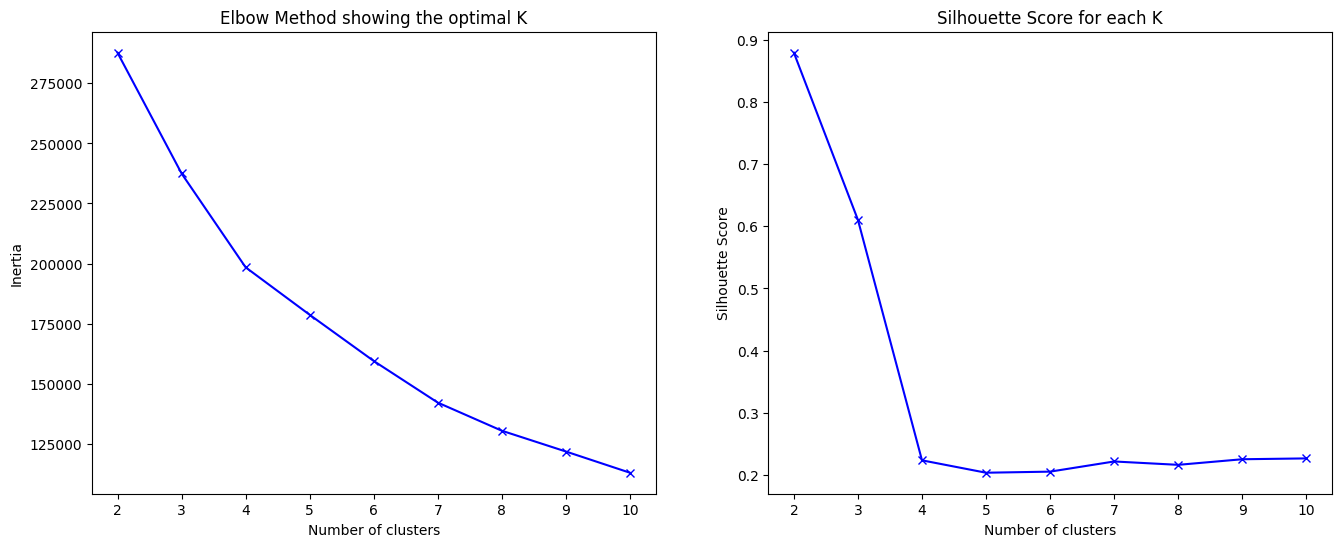

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model``

CV Scores for cluster 0: [0.53365176 0.53365176 0.53365176 0.53365176 0.53321754]


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn

CV Scores for cluster 1: [0.74768519 0.74768519 0.74768519 0.74722222 0.74722222]


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn

CV Scores for cluster 2: [0.84516129 0.73548387 0.8961039  0.81818182 0.95454545]


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn

c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


CV Scores for cluster 3: [0.76470588 0.875      0.875      0.9375     0.875     ]


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier  # Updated import

# Load the training data
features_path = 'features_train.csv'
labels_path = 'Y_train_ofTdMHi.csv'
features = pd.read_csv(features_path)
labels = pd.read_csv(labels_path)

# Data Preparation
features['region'] = features['id'].str.extract(r'-(\D+).wav')
merged_data = pd.merge(features, labels, on='id', how='left')

# Encode the 'region' column to numeric values
le = LabelEncoder()
merged_data['region_encoded'] = le.fit_transform(merged_data['region'])

# Features for clustering
X = merged_data.drop(['id', 'region', 'pos_label', 'region_encoded'], axis=1)

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
K = range(2, 11)  # Modify this range based on your expectations of the dataset

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(X_scaled)
    inertia.append(kmeanModel.inertia_)
    labels = kmeanModel.labels_
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plotting the Elbow and Silhouette methods
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method showing the optimal K')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for each K')

plt.show()

# Set the optimal number of clusters
optimal_number_of_clusters = 4  # replace with your chosen number based on the plots
# Initialize KMeans with the determined number of clusters
kmeans = KMeans(n_clusters=optimal_number_of_clusters, random_state=42)
kmeans.fit(X_scaled)


# Assign clusters to each data point
clusters = kmeans.predict(X_scaled)
merged_data['cluster'] = clusters

# Save the KMeans model
joblib.dump(kmeans, 'kmeans_model_v4.joblib')

# Save the LabelEncoder and Scaler
joblib.dump(le, 'label_encoder_v4.joblib')
joblib.dump(scaler, 'scaler_v4.joblib')

# Neural Network model
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Building and training a neural network for each cluster
for cluster_label in range(optimal_number_of_clusters):
    # Filter data for the specific cluster
    cluster_data = merged_data[merged_data['cluster'] == cluster_label]

    # Prepare data for training the neural network
    X_nn = cluster_data.drop(['id', 'region', 'pos_label', 'region_encoded', 'cluster'], axis=1)
    y_nn = cluster_data['pos_label']
    
    # Creating and compiling the model
    model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=10, verbose=0)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_nn, y_nn, cv=5)
    print(f"CV Scores for cluster {cluster_label}: {cv_scores}")

    # Training on all data
    model.fit(X_nn, y_nn)
    
    # Save the neural network model for the cluster
    model_filename = f'nn_model_cluster_{cluster_label}_v4.h5'
    
    # Access the underlying Keras model and save it
    model.model_.save(model_filename)

# Note: The rest of your prediction and loading code remains the same.

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model
import os

# Load the saved KMeans model and LabelEncoder
kmeans_loaded = joblib.load('kmeans_model_v4.joblib')
le_loaded = joblib.load('label_encoder_v4.joblib')

# Load new data for prediction
new_data_path = 'features_test.csv'
new_data = pd.read_csv(new_data_path)

# Preprocess the new data as needed (make sure to replicate preprocessing steps)
new_data['region'] = new_data['id'].str.extract(r'-(\D+).wav')

# It's important that the new data undergoes the same preprocessing as the training data.
# For example, if you encoded or transformed any features, you need to do that here too.
# ...

# Prepare the data for prediction by dropping the same columns as during training
X_new = new_data.drop(['id', 'region'], axis=1)

# Predict the clusters for the new data using the loaded KMeans model
new_data_clusters = kmeans_loaded.predict(X_new)

# Load the neural network model for each cluster and make predictions
new_data_results = []
import numpy as np

# ...

for index, data_point in new_data.iterrows():
    cluster_label = new_data_clusters[index]
    model_filename = f'nn_model_cluster_{cluster_label}_v4.h5'

    # Ensure the model file exists before trying to load it
    if os.path.exists(model_filename):
        nn_model_loaded = load_model(model_filename)
        
        # Drop 'id' and 'region' from the data point, convert to float32, and reshape for prediction
        data_point_preprocessed = data_point.drop(['id', 'region']).astype(np.float32).values.reshape(1, -1)
        
        # Make the prediction
        prediction = nn_model_loaded.predict(data_point_preprocessed)
        binary_signal = int(prediction > 0.5)
    else:
        print(f"Model file not found: {model_filename}")
        binary_signal = None

    new_data_results.append({
        'id': data_point['id'],
        'cluster': cluster_label,
        'pos_label': binary_signal
    })

# ...


# Convert the prediction results to a DataFrame and save them
predicted_df = pd.DataFrame(new_data_results)
predicted_df.to_csv('kmeans_v4.csv', index=False)


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 130ms/step


IndexError: index 1 is out of bounds for axis 0 with size 1

In [24]:
import pandas as pd

# Load the DataFrame from the CSV file
kmeans_v3 = pd.read_csv('kmeans_v4.csv')

# Drop the 'cluster' column from the DataFrame
kmeans_v3.drop(['cluster'], axis=1, inplace=True)

# Display the first few rows to verify the column is dropped
print(kmeans_v3.head())

# Save the modified DataFrame back to a CSV file
kmeans_v3.to_csv('kmeans_v4_no_cluster.csv', index=False)


               id  pos_label
0  23360-TEST.wav          0
1  23361-TEST.wav          0
2  23958-TEST.wav          0
3  23959-TEST.wav          0
4  23634-TEST.wav          1


## v6 spctro ternat v2
---

### code notebook ternat
---

In [28]:


import pandas as pd
import os
import shutil

# Chemins
y_train_path = 'Y_train_ofTdMHi.csv'  # Mettez à jour avec le chemin réel
spectrograms_dir = 'images2/'  # Dossier contenant les spectrogrammes
target_dir_0 = 'images2/classe_0/'  # Dossier cible pour la classe 0
target_dir_1 = 'images2/classe_1/'  # Dossier cible pour la classe 1

# Lire le fichier y_train.csv
y_train = pd.read_csv(y_train_path)

# Parcourir chaque entrée et déplacer les fichiers
for index, row in y_train.iterrows():
    # Chemin du fichier source
    source_path = os.path.join(spectrograms_dir, (row['id'])[:-4]+'.png')

    # Déterminer le dossier cible
    if row['pos_label'] == 0:
        target_path = os.path.join(target_dir_0, (row['id'])[:-4]+'.png')
    else:  # row['id'] == 1
        target_path = os.path.join(target_dir_1, (row['id'])[:-4]+'.png')
    
    # Déplacer le fichier
    shutil.move(source_path, target_path)

print("Fichiers déplacés avec succès.")



Fichiers déplacés avec succès.


In [29]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le dossier contenant les images de spectrogrammes
base_dir = 'images2/'

# Paramètres
img_height, img_width = 224, 224  # Taille attendue par le modèle CNN
batch_size = 32  # Taille de chaque batch

# Préparation du générateur de données
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des images
    validation_split=0.2  # Fraction des données à utiliser comme validation
)

# Générateurs pour les données d'entraînement et de validation
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary' pour classification binaire
    subset='training'  # Ensemble à utiliser pour l'entraînement
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary' pour classification binaire
    subset='validation'  # Ensemble à utiliser pour la validation
)

# Construction du modèle CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'), 
    Dense(train_generator.num_classes, activation='softmax')  # Changement pour correspondre au nombre de classes
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # ou 'binary_crossentropy' pour classification binaire
              metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5  # Ou plus, selon les besoins
)

# Enregistrement du modèle pour une utilisation ultérieure
model.save('cnn6_v1.h5')

# Vous pouvez maintenant évaluer le modèle, faire des prédictions, ou l'exporter pour une utilisation future.


Found 18535 images belonging to 2 classes.
Found 4633 images belonging to 2 classes.
Epoch 1/5
579/579 [==============================] - 742s 1s/step - loss: 0.3315 - accuracy: 0.8838 - val_loss: 0.5644 - val_accuracy: 0.7962
Epoch 2/5
579/579 [==============================] - 291s 502ms/step - loss: 0.1637 - accuracy: 0.9409 - val_loss: 0.6743 - val_accuracy: 0.8275
Epoch 3/5
579/579 [==============================] - 286s 494ms/step - loss: 0.1168 - accuracy: 0.9571 - val_loss: 0.8608 - val_accuracy: 0.7810
Epoch 4/5
579/579 [==============================] - 288s 498ms/step - loss: 0.0826 - accuracy: 0.9691 - val_loss: 0.9241 - val_accuracy: 0.8177
Epoch 5/5
579/579 [==============================] - 288s 498ms/step - loss: 0.0473 - accuracy: 0.9838 - val_loss: 0.9055 - val_accuracy: 0.8203


c:\Users\rpaul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd

# Charger le modèle entraîné
model = load_model('cnn6_v1.h5')

# Répertoire contenant les images de test
test_dir = 'images_test/'

# Créer un générateur pour les images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,  # Test one image at a time
    class_mode=None,  # Only predicting, not training
    shuffle=False  # Keep the same order
)

# Faire des prédictions
predictions = model.predict(test_generator, steps=len(test_generator.filenames))

# Supposons que 'predictions' est votre tableau de sortie du modèle de forme (950, 2)
prob_class_positive = predictions[:, 1]
prob_class_positive


# Créer un DataFrame avec les résultats
# Supposer que 'test_generator.filenames' est une liste des noms de fichiers
results_df = pd.DataFrame({
    'id': test_generator.filenames,
    'prediction': prob_class_positive # ou utiliser 'predictions' directement si binary
})

# Enregistrer les résultats dans un fichier CSV
results_df.to_csv('cnn_v6_2.csv', index=False)


Found 950 images belonging to 1 classes.
950/950 [==============================] - 15s 15ms/step


In [43]:
import pandas as pd

# Load the predictions CSV file
predictions_df = pd.read_csv('cnn_v6_2.csv')  # Replace with the actual path to your CSV file

# Load the Y_random CSV file to match the 'id' format
y_random_df = pd.read_csv('Y_random_Xwjr6aB.csv')  # Replace with the actual path to your CSV file

import pandas as pd

# Load the predictions CSV file

# Load the Y_random CSV file to match the 'id' format

# Correctly handle the directory separator depending on your operating system and the format of your 'filename'
predictions_df['id'] = predictions_df['id'].apply(lambda x: x.split('/')[-1].split('\\')[-1].replace('.png', '.wav'))

# Merge the predictions with y_random_df to align the 'id' column exactly
merged_df = pd.merge(y_random_df, predictions_df, on='id', how='inner')

# Check the columns after the merge to identify the correct column names
print(merged_df.columns)

# Assuming 'pos_label' from y_random_df and 'prediction' from predictions_df are the columns you want to keep
# Drop any unwanted columns if necessary
final_df = merged_df[['id', 'prediction']]

# Rename 'prediction' to 'pos_label'
final_df.rename(columns={'prediction': 'pos_label'}, inplace=True)

# Save the updated DataFrame to a new CSV file
final_df.to_csv('cnn_v6_22.csv', index=False)

# Check the first few rows
print(final_df.head())


Index(['id', 'pos_label', 'prediction'], dtype='object')
               id  pos_label
0  23168-TEST.wav   0.000255
1  23169-TEST.wav   0.007523
2  23170-TEST.wav   0.001126
3  23171-TEST.wav   0.012177
4  23172-TEST.wav   0.000629


C:\Users\rpaul\AppData\Local\Temp\ipykernel_1368\176191070.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'prediction': 'pos_label'}, inplace=True)
